# DSA4263 E-Commerce Fraud Analysis

## Import Packages

In [ ]:
# Uncomment if needed to install the packages
# pip install pandas numpy

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.spatial.distance import euclidean
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Data Loading

In [ ]:
# Uncomment this cell when submitting

# df_fraud = pd.read_csv("data/Fraud_Data.csv")
# df_ip_to_country = pd.read_csv("data/IpAddress_to_Country.csv")

In [ ]:
# Delete this cell when submitting

from google.colab import drive
drive.mount("/content/gdrive")
df_fraud = pd.read_csv("gdrive/MyDrive/Fraud_Data.csv")
df_ip_to_country = pd.read_csv("gdrive/MyDrive/IpAddress_to_Country.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data Preprocessing

In [ ]:
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [ ]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [ ]:
df_ip_to_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [ ]:
df_ip_to_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [ ]:
# Checking for null values and duplicates in Fraud_Data.csv

print(df_fraud.isna().sum())
print("--------------------")
print(df_fraud.duplicated().sum())

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
--------------------
0


In [ ]:
# Checking for null values and duplicates in IpAddress_to_country.csv

print(df_ip_to_country.isna().sum())
print("--------------------")
print(df_ip_to_country.duplicated().sum())

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64
--------------------
0


There are no null values and duplicate entries in both datasets.

In [ ]:
# Checking for duplicates in `user_id` and `device_id` in Fraud_Data.csv

print("No. of duplicates in user_id:", df_fraud['user_id'].duplicated().sum())
print("No. of duplicates in device_id:", df_fraud['device_id'].duplicated().sum())

No. of duplicates in user_id: 0
No. of duplicates in device_id: 13156


In [ ]:
# Merge the datasets based on Ip Address
df_clean = df_fraud
def find_country(ip_address, df_ip_ranges):
  country = df_ip_ranges[
      (df_ip_ranges['lower_bound_ip_address'] <= ip_address) &
      (df_ip_ranges['upper_bound_ip_address'] >= ip_address)
  ]['country'].values

  return country[0] if len(country) > 0 else 'Unknown'

country_values = df_clean['ip_address'].apply(find_country, df_ip_ranges=df_ip_to_country)

# Insert `country` column to the second last position of the columns
df_clean.insert(loc = len(df_clean.columns) - 1,
                column = 'country', value = country_values)

In [ ]:
# Finding the number of rows with unknown country

print("No. of unknown country:", (df_clean['country'] == 'Unknown').sum())

No. of unknown country: 21966


In [ ]:
# Calculation of IP Distance to check for potential GPS Spoofing

df_clean['ip_address'] = df_clean['ip_address'].astype(str)

# Group by device_id and check if there's more than one user_id for each device_id
duplicate_device_ids = df_clean[df_clean.duplicated(subset='device_id', keep=False)]

# If there are duplicate device ids, calculate the Euclidean distance between their IP addresses
if not duplicate_device_ids.empty:
    duplicate_device_ids['ip_address'] = duplicate_device_ids['ip_address'].astype(float)
    distances = []
    for device_id, group in duplicate_device_ids.groupby('device_id'):
        ips = group['ip_address'].tolist()
        if len(ips) > 1:
            for ip1, ip2 in combinations(ips, 2):
                distances.append((device_id, abs(ip1 - ip2)))
    distance_between_ips = pd.DataFrame(distances, columns=['device_id', 'ip_distance'])
distance_between_ips = distance_between_ips.drop_duplicates(subset='device_id')
df_clean = pd.merge(df_clean, distance_between_ips, on='device_id', how='left')

<ipython-input-57-631f334d4df2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate_device_ids['ip_address'] = duplicate_device_ids['ip_address'].astype(float)


In [ ]:
df_clean.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,country,class,ip_distance
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.79972,Japan,0,NaN
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.865908,United States,0,NaN
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11095,United States,1,0.0


In [ ]:
# Extracting the year when customers signup for accounts
df_clean['signup_time'] = pd.to_datetime(df_clean['signup_time'], format='%Y-%m-%d %H:%M:%S')
df_clean['year'] = df_clean['signup_time'].dt.year
print("Earliest year for signup:", df_clean['year'].min())
print("Latest year for signup:", df_clean['year'].max())

Earliest year for signup: 2015
Latest year for signup: 2015


In [ ]:
# Since the data is only for year 2015, we remove the year column
df_clean.drop('year', axis=1, inplace=True)

In [ ]:
# Extracting the months when customers signup for accounts
df_clean['signup_month'] = df_clean['signup_time'].dt.month
# Range of the months when customers signup for accounts
print("Earliest month for signup:", df_clean['signup_month'].min())
print("Latest month for signup:", df_clean['signup_month'].max())

Earliest month for signup: 1
Latest month for signup: 8


In [ ]:
# Extracting the days of the month when customers signup for accounts
df_clean['signup_day'] = df_clean['signup_time'].dt.day
print("Earliest day for signup:", df_clean['signup_day'].min())
print("Latest day for signup:", df_clean['signup_day'].max())

Earliest day for signup: 1
Latest day for signup: 31


In [ ]:
# Extracting the year when customers made a purchase
df_clean['purchase_time'] = pd.to_datetime(df_clean['purchase_time'], format='%Y-%m-%d %H:%M:%S')
df_clean['purchase_year'] = df_clean['purchase_time'].dt.year
print("Earliest year for purchase:", df_clean['purchase_year'].min())
print("Latest year for purchase:", df_clean['purchase_year'].max())

Earliest year for purchase: 2015
Latest year for purchase: 2015


In [ ]:
# Since the data is only for year 2015, we remove the year column
df_clean.drop('purchase_year', axis=1, inplace=True)

In [ ]:
# Extracting the months when customers signup for accounts
df_clean['purchase_month'] = df_clean['purchase_time'].dt.month
# Range of the months when customers made purchases
print("Earliest month for purchase:", df_clean['purchase_month'].min())
print("Latest month for purchase:", df_clean['purchase_month'].max())

Earliest month for purchase: 1
Latest month for purchase: 12


In [ ]:
# Extracting the days of the month when customers signup for accounts
df_clean['purchase_day'] = df_clean['purchase_time'].dt.day
print("Earliest day for purchase:", df_clean['purchase_day'].min())
print("Latest day for purchase:", df_clean['purchase_day'].max())

Earliest day for purchase: 1
Latest day for purchase: 31


In [ ]:
# Finding out the difference in time between account creation time and time of purchase, in seconds
df_clean['signup_purchase_time_diff'] = (df_clean['purchase_time']-df_clean['signup_time']).dt.total_seconds()

#sort the dataframe by device_id and purchase_time
df_clean.sort_values(by=['device_id', 'purchase_time'], inplace=True)

#time difference in minutes between purchase time for previous purchase and current purchase for each device id
df_clean['time_diff_prev_purchase'] = df_clean.groupby('device_id')['purchase_time'].diff().dt.total_seconds()

#number of user id that have been created under each device id
df_clean['num_users_per_device'] = df_clean.groupby('device_id')['user_id'].transform('nunique')

#number of unique IPs per device id
df_clean['num_unique_ips_per_device'] = df_clean.groupby('device_id')['ip_address'].transform('nunique')

# number of unique user ids per IP
df_fraud['num_users_per_ip'] = df_fraud.groupby('ip_address')['user_id'].transform('nunique')

#average purchase value per device id
df_clean['avg_purchase_value_per_device'] = df_clean.groupby('device_id')['purchase_value'].transform('mean')
df_clean['high_value_purchase'] = df_clean['purchase_value'] > (2 * df_clean['avg_purchase_value_per_device'])
df_clean['high_value_purchase'] = df_clean['high_value_purchase'].astype(int)

frequent_items = df_clean['purchase_value'].value_counts().index[:3]  # Example: Top 3 frequent purchase values
df_clean['frequent_purchase'] = df_clean['purchase_value'].isin(frequent_items).astype(int)

# Feature 3: Number of accounts per IP address
df_clean['num_users_per_ip'] = df_clean.groupby('ip_address')['user_id'].transform('nunique')

# Fill NaN values in time difference columns with 0
df_clean['time_diff_prev_purchase'].fillna(0, inplace=True)

# Categorise users who made purchases immediately after signing up for account
df_clean['immediate_purchase'] = np.where(df_clean['signup_purchase_time_diff'] <= 1, 1, 0)

# Users who previously committed fraud
df_clean = df_clean.sort_values(['device_id', 'ip_address', 'purchase_time'])
df_clean['previous_fraud'] = df_clean.duplicated(subset=['device_id', 'ip_address'], keep=False) & (df_clean['class'] == 1)
df_clean['previous_fraud'] = df_clean.groupby(['device_id', 'ip_address'])['previous_fraud'].shift(fill_value=False)
df_clean['previous_fraud'] = df_clean['previous_fraud'].astype(int)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151112 entries, 34321 to 54293
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   user_id                        151112 non-null  int64         
 1   signup_time                    151112 non-null  datetime64[ns]
 2   purchase_time                  151112 non-null  datetime64[ns]
 3   purchase_value                 151112 non-null  int64         
 4   device_id                      151112 non-null  object        
 5   source                         151112 non-null  object        
 6   browser                        151112 non-null  object        
 7   sex                            151112 non-null  object        
 8   age                            151112 non-null  int64         
 9   ip_address                     151112 non-null  object        
 10  country                        151112 non-null  object        
 11  cl

In [ ]:
# Listing string type data that can be transformed into categorical data
print("Types of browsers used by customers:", df_clean['browser'].unique())
print("Types of sources that customers use to reach the ecommerce platform", df_clean['source'].unique())
print("Types of genders of customers:", df_clean['sex'].unique())

Types of browsers used by customers: ['Chrome' 'IE' 'FireFox' 'Opera' 'Safari']
Types of sources that customers use to reach the ecommerce platform ['Direct' 'Ads' 'SEO']
Types of genders of customers: ['M' 'F']


In [ ]:
# Perform One-Hot Encoding to convert Browser, Sex and Source columns into numerical columns
ohe_df = pd.get_dummies(df_clean, columns=['browser','sex','source'])
boolean_cols = ['browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari',
                'sex_F', 'sex_M',
                'source_Ads', 'source_Direct', 'source_SEO']
ohe_df[boolean_cols] = ohe_df[boolean_cols].astype(int)
ohe_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,country,class,ip_distance,...,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,source_Ads,source_Direct,source_SEO
34321,226648,2015-05-12 16:00:31,2015-06-13 23:42:18,45,AAALBGNHHVMKG,34,2494581089.26598,United Kingdom,0,NaN,...,1,0,0,0,0,0,1,0,1,0
57616,103319,2015-02-05 22:20:04,2015-03-29 00:39:07,94,AAAWIHVCQELTP,29,809263681.299282,United States,0,NaN,...,1,0,0,0,0,0,1,1,0,0
46520,36633,2015-05-10 00:49:53,2015-07-22 03:18:01,46,AAAXJHWCLISKY,40,2891496.87452835,Unknown,0,NaN,...,0,0,1,0,0,0,1,1,0,0
69175,325729,2015-01-01 04:25:22,2015-01-01 04:25:23,57,AAAXXOZJRZRAO,36,1377849233.09361,United Kingdom,1,0.0,...,0,1,0,0,0,1,0,1,0,0
35860,64674,2015-01-01 04:25:23,2015-01-01 04:25:24,57,AAAXXOZJRZRAO,36,1377849233.09361,United Kingdom,1,0.0,...,0,1,0,0,0,1,0,1,0,0


In [ ]:
# Checking for class imbalance
print("Number of Non-Fraudulent transactions:", df_clean['class'].value_counts()[0])
print("Number of Fraudulent transactions:", df_clean['class'].value_counts()[1])

Number of Non-Fraudulent transactions: 136961
Number of Fraudulent transactions: 14151


Class imbalance exists.

## EDA

### Analysis on Time Difference between Purchase and Signup

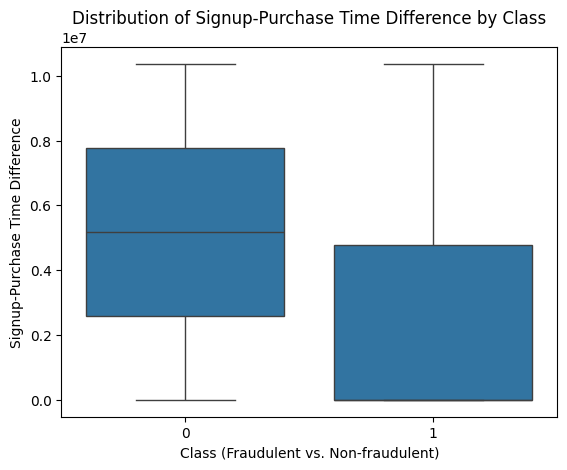

In [ ]:
# Plot 1
# Plotting boxplot to visualise the difference between signup-purchase time difference for each class
sns.boxplot(x='class', y='signup_purchase_time_diff', data=df_clean)
plt.xlabel('Class (Fraudulent vs. Non-fraudulent)')
plt.ylabel('Signup-Purchase Time Difference')
plt.title('Distribution of Signup-Purchase Time Difference by Class')
plt.show()

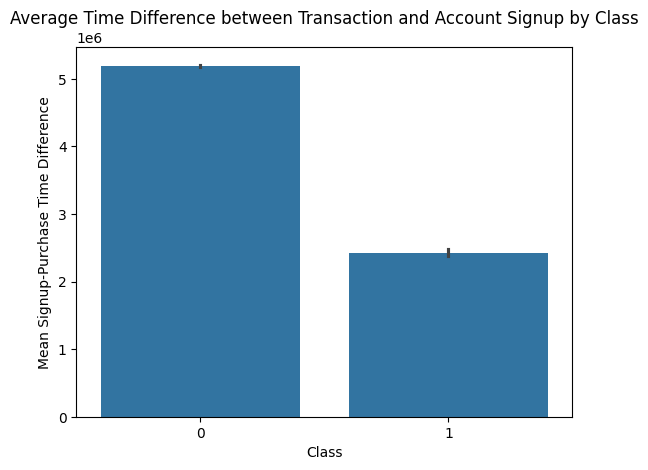

In [ ]:
# Plot 2
# Plotting bar chart to visualise the average signup-purchase time difference for each class
sns.barplot(data=df_clean, x='class', y='signup_purchase_time_diff')
plt.xlabel('Class')
plt.ylabel('Mean Signup-Purchase Time Difference')
plt.title('Average Time Difference between Transaction and Account Signup by Class')
plt.show()

Insights: The 2 plots above show that non-fraudulent users have a longer period of time between account signup and making transaction, as compared to fraudulent users, which implies that fraudulent users could be signing up for accounts already with the intention to commit frauds.

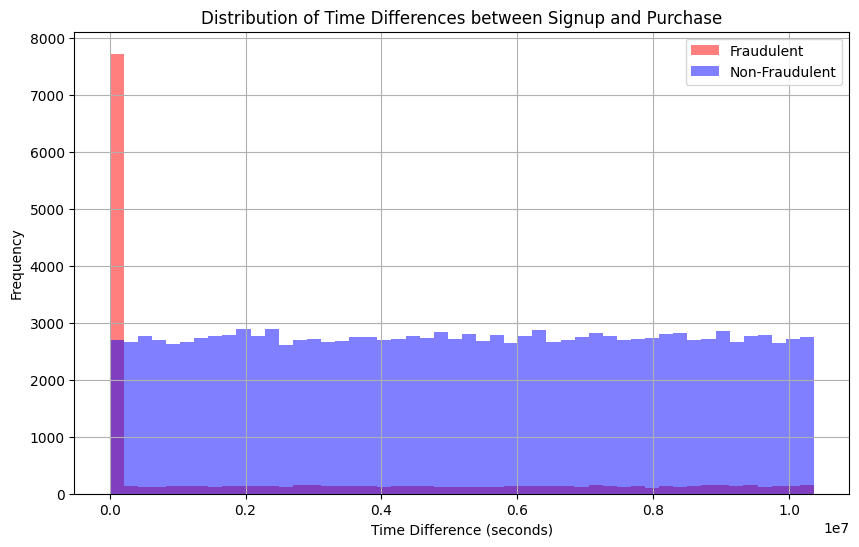

In [ ]:
# Plot 3
# Distribution of time difference between signup and purchase for both classes

fraudulent = df_clean[df_clean['class'] == 1]
non_fraudulent = df_clean[df_clean['class'] == 0]

plt.figure(figsize=(10, 6))
plt.hist(fraudulent['signup_purchase_time_diff'], bins=50, alpha=0.5, color='red', label='Fraudulent')
plt.hist(non_fraudulent['signup_purchase_time_diff'], bins=50, alpha=0.5, color='blue', label='Non-Fraudulent')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Time Differences between Signup and Purchase')
plt.legend()
plt.grid(True)
plt.show()

Insights: The plot shows that the time difference between signup and purchase for non-fraudulent transactions is approximately uniform, while that of fraudulent transaction is a heavy left-tail distribution. This coincides with the insight generated from Plots 1 and 2.

<Figure size 1000x600 with 0 Axes>

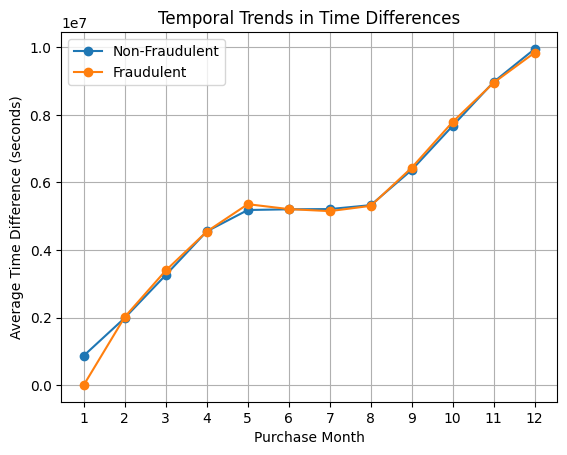

In [ ]:
# Plot 4
# Temporal trends in time differences between signup and purchase for both classes
avg_time_difference = df_clean.groupby(['purchase_month', 'class'])['signup_purchase_time_diff'].mean().reset_index()

# Pivot the table for plotting
pivot_table = avg_time_difference.pivot(index='purchase_month', columns='class', values='signup_purchase_time_diff')

# Plot the temporal trends
plt.figure(figsize=(10, 6))
pivot_table.plot(kind='line', marker='o')
plt.xlabel('Purchase Month')
plt.ylabel('Average Time Difference (seconds)')
plt.title('Temporal Trends in Time Differences')
plt.xticks(range(1, 13))  # Assuming months are represented as integers from 1 to 12
plt.grid(True)
plt.legend(['Non-Fraudulent', 'Fraudulent'])
plt.show()

### Analysis on Immediate Purchase

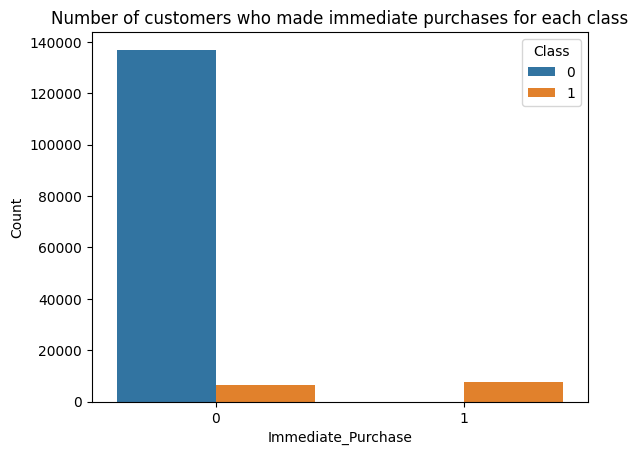

immediate_purchase  class
0                   0        136961
                    1          6551
1                   1          7600
dtype: int64

In [ ]:
# Plot 1
# Plotting bar chart to visualise number of customers who made immediate purchases for each class
sns.countplot(data=df_clean, x='immediate_purchase', hue='class')
plt.xlabel('Immediate_Purchase')
plt.ylabel('Count')
plt.legend(title='Class')
plt.title("Number of customers who made immediate purchases for each class")
plt.show()

df_clean.groupby(['immediate_purchase', 'class']).size()

Insights: All the transactions made 1s after sign-up are fraudulent ones

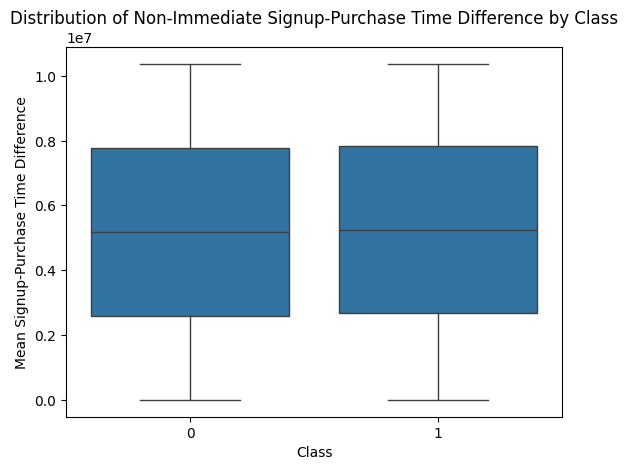

In [ ]:
# Plot 2
# Plotting boxplot to visualise the time difference between purchase and signup for customers who did not make immediate purchases for each class
sns.boxplot(data=df_clean[df_clean['immediate_purchase']==0], x='class', y='signup_purchase_time_diff')
plt.xlabel('Class')
plt.ylabel('Mean Signup-Purchase Time Difference')
plt.title('Distribution of Non-Immediate Signup-Purchase Time Difference by Class')
plt.show()

Insights: The distribution of 'signup-purchase time difference' between non-fraudulent vs fraudulent are the same from ones where the time difference > 1s

### Analysis on IP (Add insights)

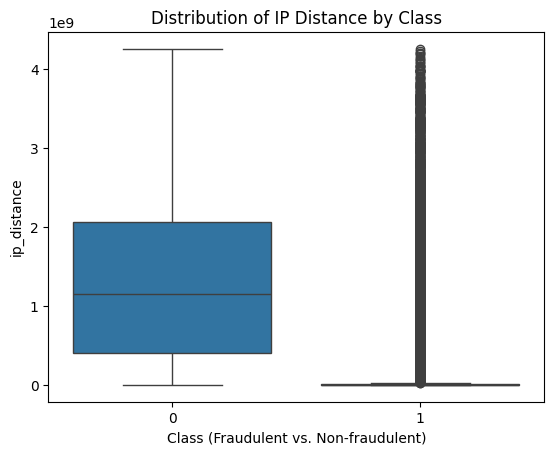

In [ ]:
# Plot 1
# Plotting boxplot to visualise the difference between ip_distance for each class
sns.boxplot(x='class', y='ip_distance', data=df_clean)
plt.xlabel('Class (Fraudulent vs. Non-fraudulent)')
plt.ylabel('ip_distance')
plt.title('Distribution of IP Distance by Class')
plt.show()

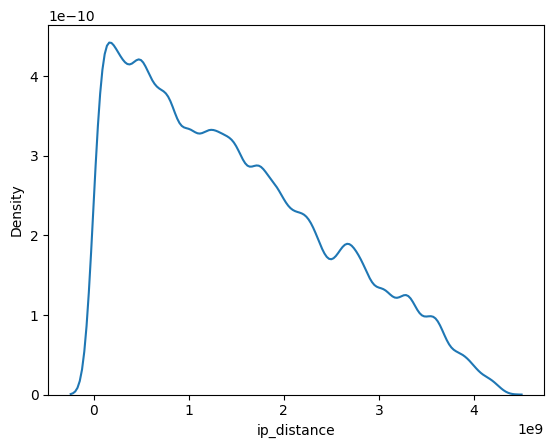

In [ ]:
# Plot 2
# Distribution of IP distance > 0
sns.kdeplot(df_clean[df_clean['ip_distance']>0]['ip_distance'], bw_adjust=0.5)
plt.show()

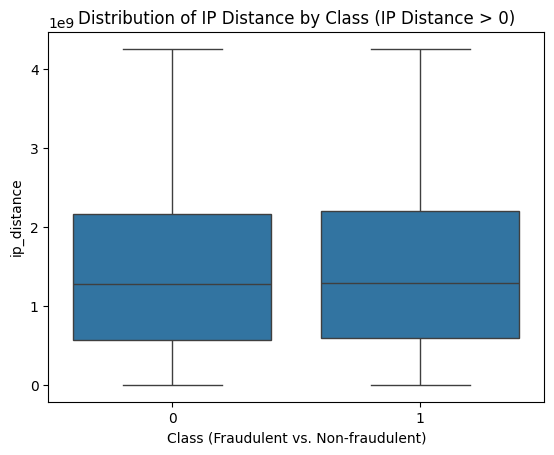

In [ ]:
# Plot 3
# Distribution of IP Distance by class, for transactions where IP distance > 0
sns.boxplot(x='class', y='ip_distance', data=df_clean[df_clean['ip_distance']>0])
plt.xlabel('Class (Fraudulent vs. Non-fraudulent)')
plt.ylabel('ip_distance')
plt.title('Distribution of IP Distance by Class (IP Distance > 0)')
plt.show()

Insights: IP distance for both classes have similar distribution, for users where IP distance > 0.

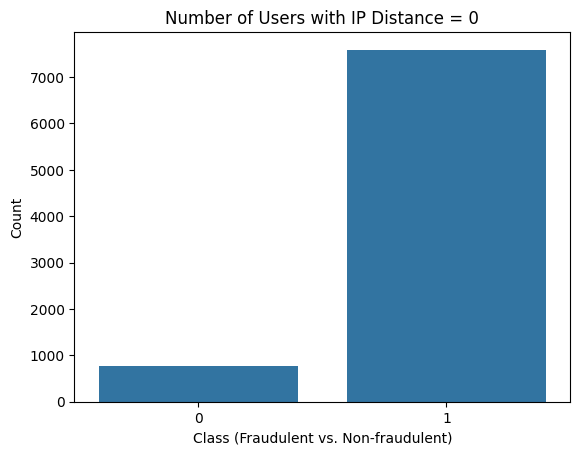

In [ ]:
# Plot 4
# Plot to visualise number of users for each class with IP distance = 0
sns.countplot(x = df_clean[df_clean['ip_distance']==0]['class'])
plt.xlabel('Class (Fraudulent vs. Non-fraudulent)')
plt.ylabel('Count')
plt.title("Number of Users with IP Distance = 0")
plt.show()

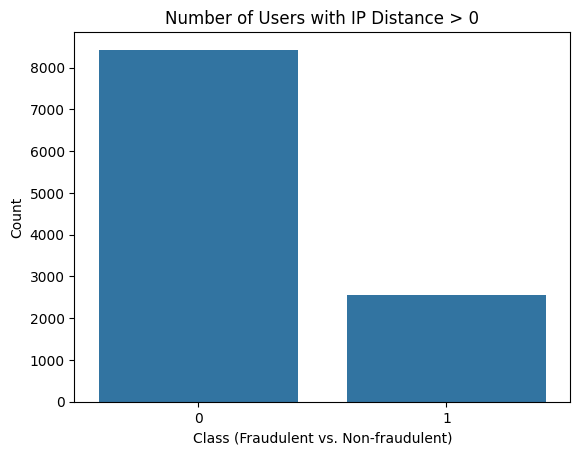

In [ ]:
# Plot 5
# Plot to visualise number of users for each class when IP distance > 0
sns.countplot(x = df_clean[df_clean['ip_distance']>0]['class'])
plt.xlabel('Class (Fraudulent vs. Non-fraudulent)')
plt.ylabel('Count')
plt.title("Number of Users with IP Distance > 0")
plt.show()

Insights: From the graphs, the mean ip distance for non-frauduluent transactions is higher compared to the fraudulent ones. This differs from what we have predicted that fraudulent users may engage in GPS spoofing which led to a great change in ip distance which will lead to higher ip distance.

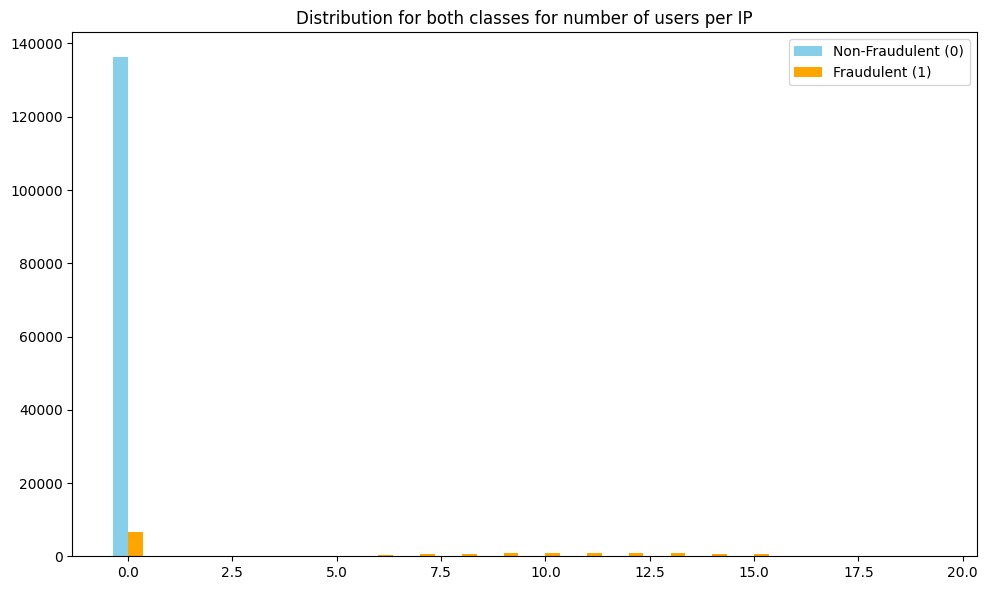

In [ ]:
# Plot 6
# Distribution of number of users per ips for both classes
plt.figure(figsize=(10, 6))

grouped_df = df_clean.groupby(['num_users_per_ip', 'class']).size().unstack(fill_value=0)
x = np.arange(len(grouped_df))
width = 0.35
plt.bar(x - width/2, grouped_df[0], width, label='Non-Fraudulent (0)', color='skyblue')
plt.bar(x + width/2, grouped_df[1], width, label='Fraudulent (1)', color='orange')
plt.title("Distribution for both classes for number of users per IP")
plt.legend()
plt.tight_layout()
plt.show()

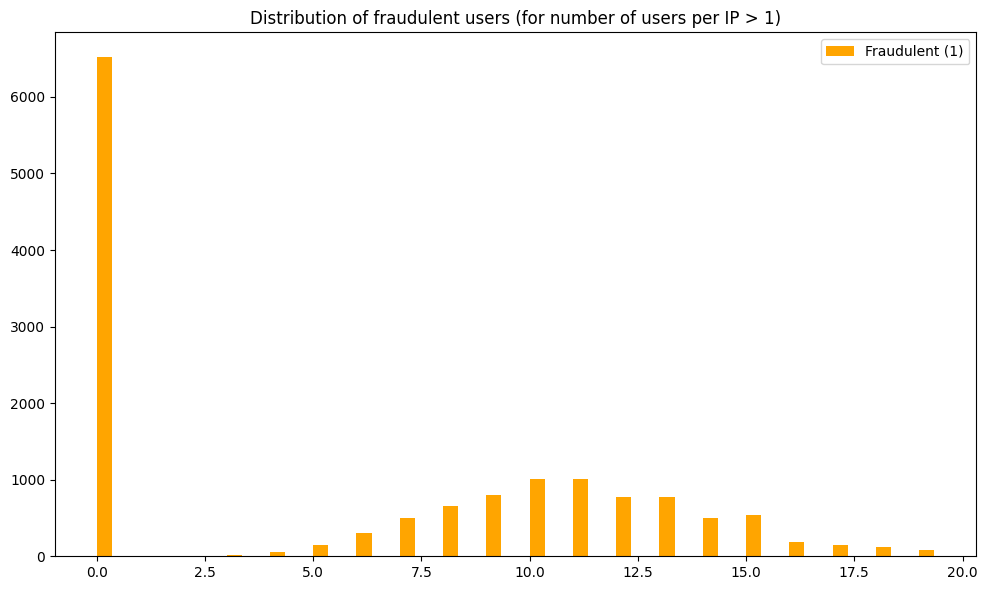

In [ ]:
# Plot 7
# Distribution of fraudulent users per IP > 1 for both classes, since 1 is highest proportion
plt.figure(figsize=(10, 6))

grouped_df = df_clean[df_clean['class'] == 1].groupby('num_users_per_ip').size()
x = np.arange(len(grouped_df))
width = 0.35
plt.bar(x + width/2, grouped_df, width, label='Fraudulent (1)', color='orange')
plt.title("Distribution of fraudulent users (for number of users per IP > 1)")
plt.legend()
plt.tight_layout()
plt.show()

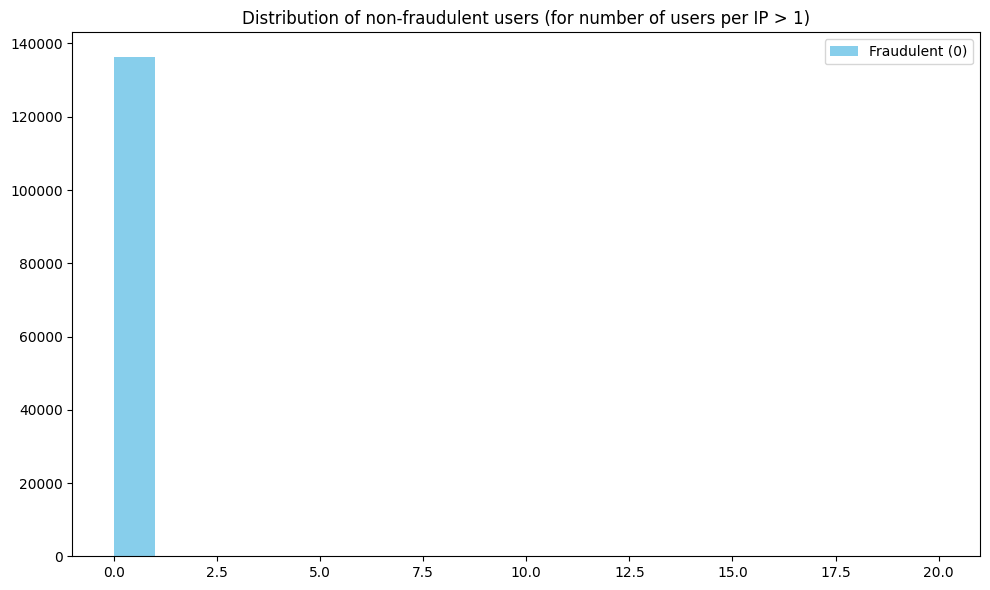

In [ ]:
# Plot 8
# Distribution of non-fraudulent users per IP > 1 for both classes, since 1 is highest proportion
plt.figure(figsize=(10, 6))

grouped_df = df_clean[(df_clean['class'] == 0)].groupby('num_users_per_ip').size()
x = np.arange(len(grouped_df))
width = 1
plt.bar(x + width/2, grouped_df, width, label='Fraudulent (0)', color='skyblue')
plt.title("Distribution of non-fraudulent users (for number of users per IP > 1)")
plt.legend()
plt.tight_layout()
plt.show()

Insights: Non-fraudulent users typically have only 1 account on their IP, while fraudulent users are more likely to create multiple accounts on their IP.

### Analysis on Device ID

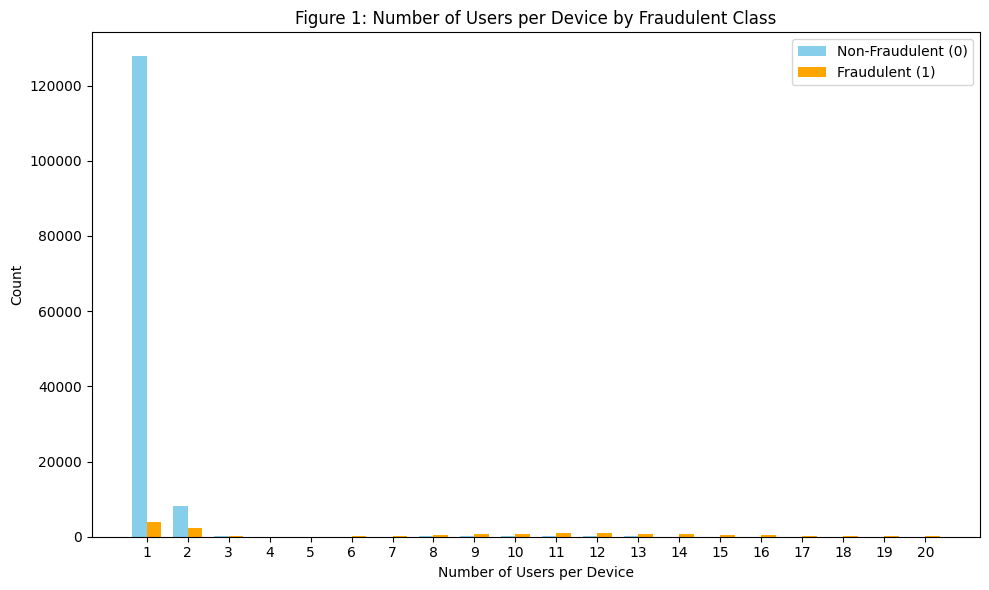

In [ ]:
# Plot 1
# Plot the distribution of the number of user id per device id for both classes
plt.figure(figsize=(10, 6))

#[(df_clean['num_users_per_device'] > 1)]
grouped_df = df_clean.groupby(['num_users_per_device', 'class']).size().unstack(fill_value=0)
x = np.arange(len(grouped_df))
width = 0.35
plt.bar(x - width/2, grouped_df[0], width, label='Non-Fraudulent (0)', color='skyblue')
plt.bar(x + width/2, grouped_df[1], width, label='Fraudulent (1)', color='orange')

plt.title('Figure 1: Number of Users per Device by Fraudulent Class')
plt.xlabel('Number of Users per Device')
plt.ylabel('Count')
plt.xticks(x, grouped_df.index)

plt.legend()
plt.tight_layout()
plt.show()

As seen in Figure 1, there is an obvious skew in the distribution, characterised by the device IDs associated with 1 user ID, which is the most typical and expected pattern. It aligns with the expected user device pattern but as it significantly skews the distribution, making it difficult to observe patterns for device IDs with multiple user IDs. Hence, values greater than 1 was selected for Figure 2.

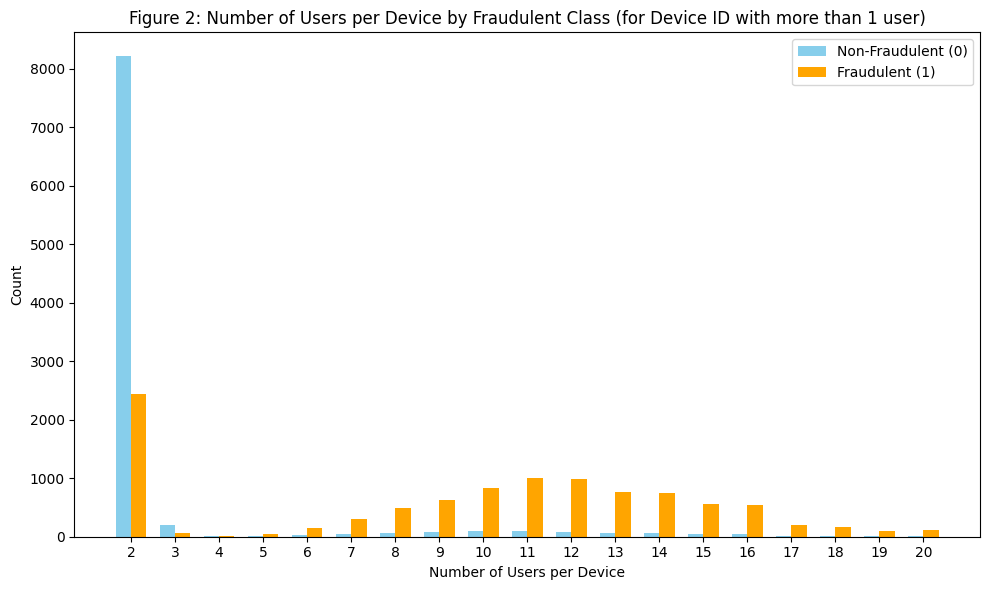

In [ ]:
# Plot 2
# Distribution of number of users per device id > 1 for both classes, since 1 is highest proportion
plt.figure(figsize=(10, 6))

grouped_df = df_clean[(df_clean['num_users_per_device'] > 1)].groupby(['num_users_per_device', 'class']).size().unstack(fill_value=0)
x = np.arange(len(grouped_df))
width = 0.35
plt.bar(x - width/2, grouped_df[0], width, label='Non-Fraudulent (0)', color='skyblue')
plt.bar(x + width/2, grouped_df[1], width, label='Fraudulent (1)', color='orange')

plt.title('Figure 2: Number of Users per Device by Fraudulent Class (for Device ID with more than 1 user)')
plt.xlabel('Number of Users per Device')
plt.ylabel('Count')
plt.xticks(x, grouped_df.index)

plt.legend()
plt.tight_layout()
plt.show()

Based on Figure 2, we can see that for non-fraudulent transactions, they mostly have 1 user ID per Device ID, following 2. Whereas for fraudulent transactions, it is also mostly 1 user ID per Device ID, followed by 2. There is also a significant number of transactions ranging from values 5 to 20, with a normal distribution having mean 12 (Figure 3).

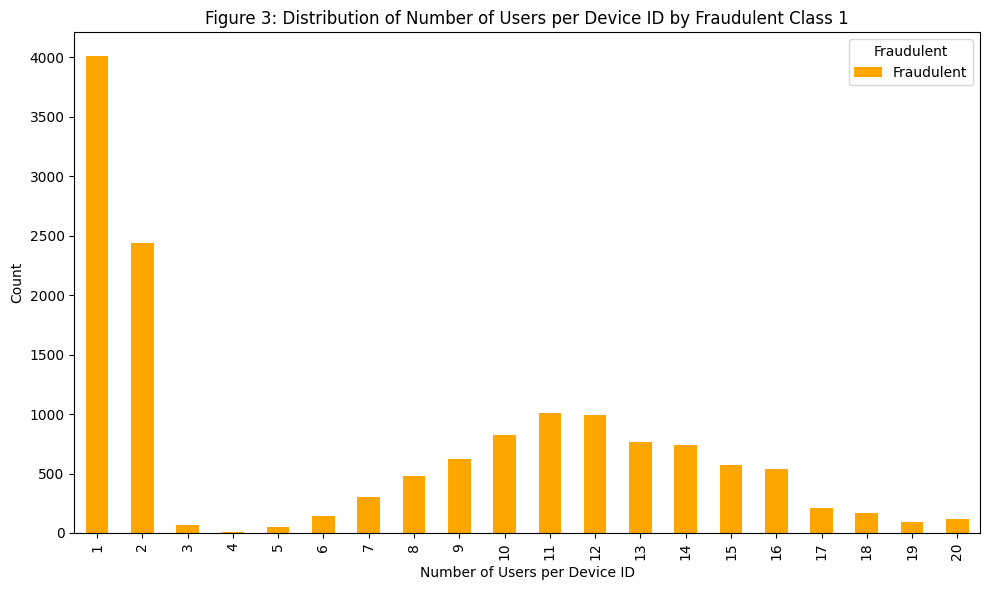

In [ ]:
# Plot 3
# Plot the distribution of the number of users per device id for fruadulent class
plt.figure(figsize=(10, 6))

grouped_df = df_clean[df_clean['class'] == 1].groupby('num_users_per_device').size()
grouped_df.plot(kind='bar', color=['orange'])

plt.title('Figure 3: Distribution of Number of Users per Device ID by Fraudulent Class 1')
plt.xlabel('Number of Users per Device ID')
plt.ylabel('Count')

plt.legend(title='Fraudulent', labels=['Fraudulent'])
plt.tight_layout()
plt.show()

Hypothesis: Devices used for fraudulent transactions are more likely to exhibit a higher number of user_id being linked to it as compared to devices used for legitimate transactions.

Insights: The number of users per device for fraudulent transactions is greater than that of non-fraudulent ones, implying that frauds tend to create multiple accounts on their devices, while non-frauds have a lesser tendency to do so.

### Analysis on Previous Frauds

In [ ]:
# Check whether there exists previous fraudulent transactions with same device_id and ip_address
df_clean = df_clean.sort_values(['device_id', 'ip_address', 'purchase_time'])
df_clean['previous_fraud'] = df_clean.duplicated(subset=['device_id', 'ip_address'], keep=False) & (df_clean['class'] == 1)
df_clean['previous_fraud'] = df_clean.groupby(['device_id', 'ip_address'])['previous_fraud'].shift(fill_value=False)
df_clean['previous_fraud'] = df_clean['previous_fraud'].astype(int)

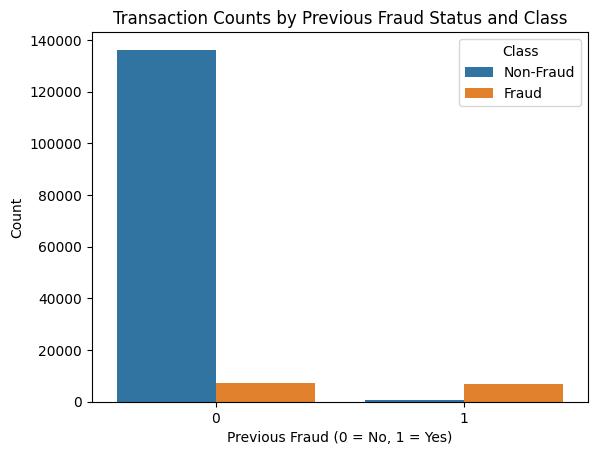

previous_fraud  class
0               0        136235
                1          7277
1               0           726
                1          6874
dtype: int64

In [ ]:
# Plot 1
# Plot to visualise number of transactions made by each class, based on previous fraud records
sns.countplot(data=df_clean, x='previous_fraud', hue='class')
plt.xlabel('Previous Fraud (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.title('Transaction Counts by Previous Fraud Status and Class')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.show()
df_clean.groupby(['previous_fraud', 'class']).size()

Insights: There is similar count of those who committed previous frauds and those who did not for the fraud class, which may imply that fraudulent users use their accounts to make fraudulent transactions more than once. Some non-fraudulent transactions are made by previously fraudulent users, therefore, using previous frauds as a feature to predict if a user is fraud may lead to false positives.

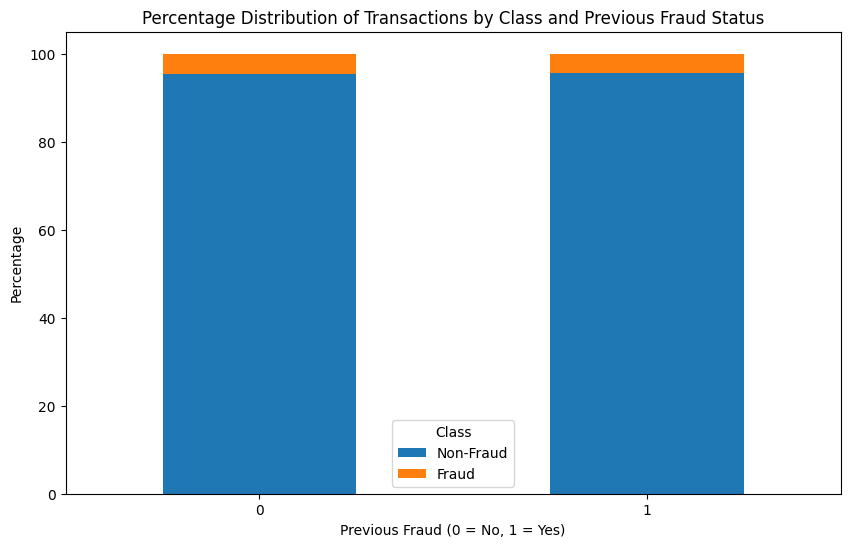

class,0,1
previous_fraud,,
0,95.434740,4.565260
1,95.526316,4.473684


In [ ]:
# Plot 2
# Plot to visualise proportion of fraudulent vs non-fraudulent transactions, faceted by users who previously committed fraud
grouped_counts = df_clean[df_clean['immediate_purchase']==0].groupby(['previous_fraud', 'class']).size().unstack()
grouped_percentage = grouped_counts.div(grouped_counts.sum(axis=1), axis=0) * 100
grouped_percentage.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Previous Fraud (0 = No, 1 = Yes)')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Transactions by Class and Previous Fraud Status')
plt.legend(title='Class', labels=['Non-Fraud', 'Fraud'])
plt.xticks(rotation=0, ha='center')
plt.show()
grouped_percentage

Insights: The percentage of fraudulent and non-fraudulent transactions is similar between those who previously committed frauds and those who did not.

### General Analysis on common traits

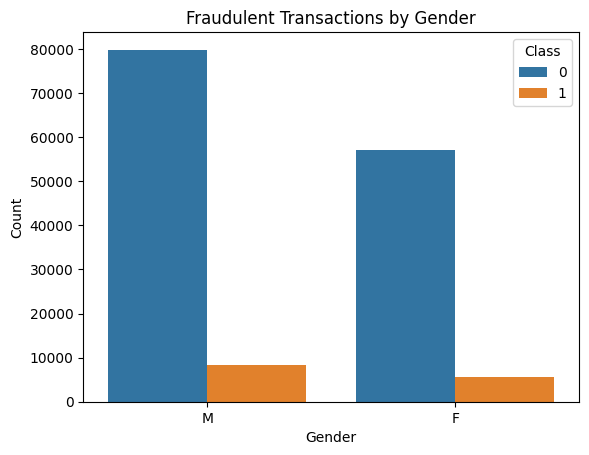

In [ ]:
# Plot 1
# Plotting bar chart to visualise the numbers of fraudulent users vs non-fraudulent users by gender
sns.countplot(data=df_clean, x='sex', hue='class')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Fraudulent Transactions by Gender')
plt.legend(title='Class')
plt.show()

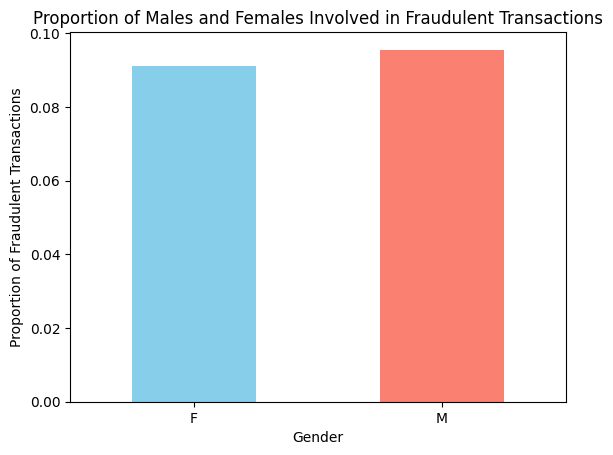

In [ ]:
# Plot 2
# Plotting bar chart to visualise the proportion of male vs females being frauds
fraud_proportion_by_gender = df_clean.groupby('sex')['class'].apply(lambda x: (x == 1).mean())

fraud_proportion_by_gender.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Gender')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.title('Proportion of Males and Females Involved in Fraudulent Transactions')
plt.xticks(rotation=0)
plt.show()

Insights: While more males appear to be fraudulent users, the proportion of males and females fraud users appear to imply that there is little association between a user being fraud and his/her gender.

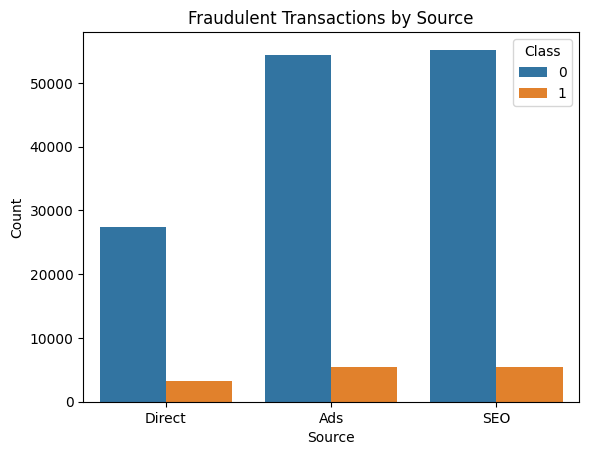

In [ ]:
# Plot 3
# Plotting bar chart to visualise the numbers of fraudulent users vs non-fraudulent users by Source
sns.countplot(data=df_clean, x='source', hue='class')
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Fraudulent Transactions by Source')
plt.legend(title='Class')
plt.show()

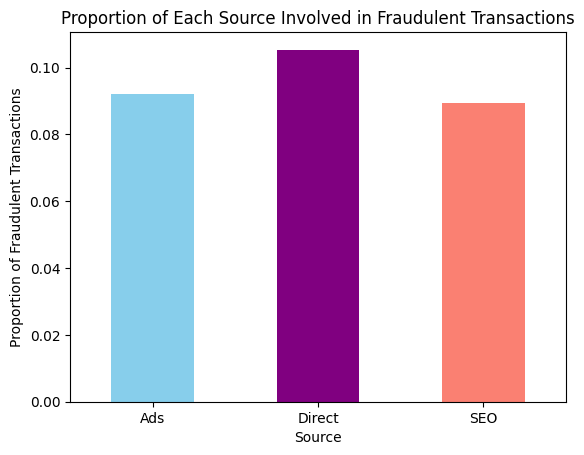

In [ ]:
# Plot 4
# Plotting bar chart to visualise the proportion of each source's customers being frauds
fraud_proportion_by_gender = df_clean.groupby('source')['class'].apply(lambda x: (x == 1).mean())

fraud_proportion_by_gender.plot(kind='bar', color=['skyblue', 'purple','salmon'])
plt.xlabel('Source')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.title('Proportion of Each Source Involved in Fraudulent Transactions')
plt.xticks(rotation=0)
plt.show()

Insights: While the number of fradulent users for each source appears similar, fraudulent users who source the ecommerce platform directly are the most compared to the 3 groups. This could potentially mean that these fraudulent users have already targeted the platform, and hence there is no need to enter the platform via ads or SEOs.

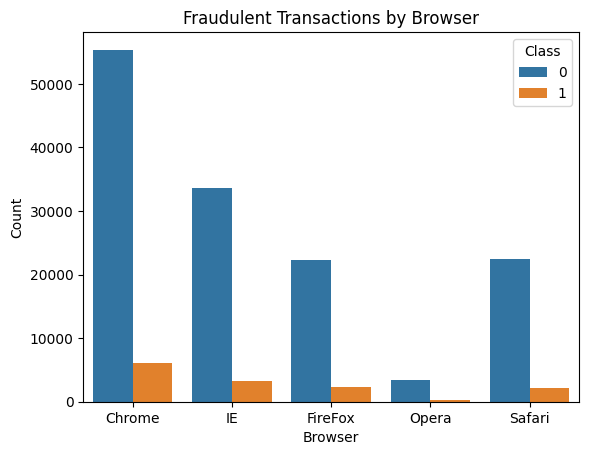

In [ ]:
# Plot 5
# Plotting bar chart to visualise the numbers of fraudulent users vs non-fraudulent users by Browser
sns.countplot(data=df_clean, x='browser', hue='class')
plt.xlabel('Browser')
plt.ylabel('Count')
plt.title('Fraudulent Transactions by Browser')
plt.legend(title='Class')
plt.show()

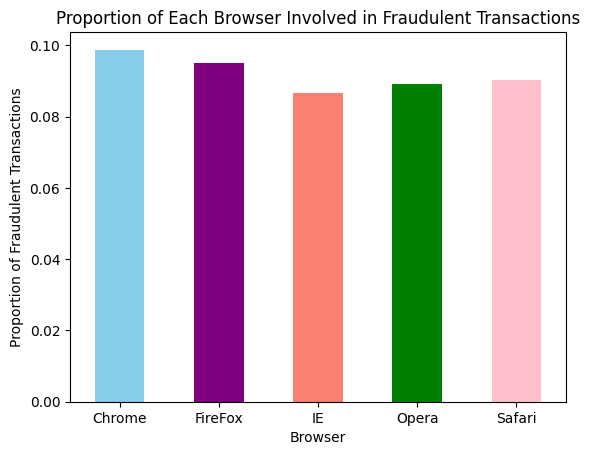

In [ ]:
# Plot 6
# Plotting bar chart to visualise the proportion of each browser's users being frauds
fraud_proportion_by_gender = df_clean.groupby('browser')['class'].apply(lambda x: (x == 1).mean())

fraud_proportion_by_gender.plot(kind='bar', color=['skyblue', 'purple','salmon','green','pink'])
plt.xlabel('Browser')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.title('Proportion of Each Browser Involved in Fraudulent Transactions')
plt.xticks(rotation=0)
plt.show()

Insights: Proportion wise, all browsers have similar level of fraudulent users. However, Chrome has the highest user count, and therefore fraudulent users are more likely to reach the platform through Chrome.

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151112 entries, 34321 to 54293
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   user_id                        151112 non-null  int64         
 1   signup_time                    151112 non-null  datetime64[ns]
 2   purchase_time                  151112 non-null  datetime64[ns]
 3   purchase_value                 151112 non-null  int64         
 4   device_id                      151112 non-null  object        
 5   source                         151112 non-null  object        
 6   browser                        151112 non-null  object        
 7   sex                            151112 non-null  object        
 8   age                            151112 non-null  int64         
 9   ip_address                     151112 non-null  object        
 10  country                        151112 non-null  object        
 11  cl

In [ ]:
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151112 entries, 34321 to 54293
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   user_id                        151112 non-null  int64         
 1   signup_time                    151112 non-null  datetime64[ns]
 2   purchase_time                  151112 non-null  datetime64[ns]
 3   purchase_value                 151112 non-null  int64         
 4   device_id                      151112 non-null  object        
 5   age                            151112 non-null  int64         
 6   ip_address                     151112 non-null  object        
 7   country                        151112 non-null  object        
 8   class                          151112 non-null  int64         
 9   ip_distance                    19331 non-null   float64       
 10  signup_month                   151112 non-null  int32         
 11  si

In [ ]:
# Number of null entries in IP Distance column
# Since there are too many null entries, IP Distance column will be dropped
ohe_df['ip_distance'].isnull().sum()

131781

In [ ]:
ohe_df.drop(columns=["signup_time","purchase_time", "user_id", "ip_distance"], inplace=True)
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151112 entries, 34321 to 54293
Data columns (total 30 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   purchase_value                 151112 non-null  int64  
 1   device_id                      151112 non-null  object 
 2   age                            151112 non-null  int64  
 3   ip_address                     151112 non-null  object 
 4   country                        151112 non-null  object 
 5   class                          151112 non-null  int64  
 6   signup_month                   151112 non-null  int32  
 7   signup_day                     151112 non-null  int32  
 8   purchase_month                 151112 non-null  int32  
 9   purchase_day                   151112 non-null  int32  
 10  signup_purchase_time_diff      151112 non-null  float64
 11  time_diff_prev_purchase        151112 non-null  float64
 12  num_users_per_device           1

## Feature Engineering

In this section, we performed feature engineering techniques to modify our dataset. First, we used target encoding to transform the country column into numeric, by calculating the mean of the class value for each unique country. Subsequently, we checked for correlation between features, and removing features that are highly correlated with one another to reduce the dimension of our data.

In [ ]:
# Perform Target Encoding for the 'country' column

encoder = TargetEncoder()

# Fit the target encoder to the 'country' column and transform it
ohe_df['country_encoded'] = encoder.fit_transform(ohe_df['country'], ohe_df['class'])
ohe_df.drop(columns=['country','device_id', 'ip_address'], inplace=True)

In [ ]:
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 151112 entries, 34321 to 54293
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   purchase_value                 151112 non-null  int64  
 1   age                            151112 non-null  int64  
 2   class                          151112 non-null  int64  
 3   signup_month                   151112 non-null  int32  
 4   signup_day                     151112 non-null  int32  
 5   purchase_month                 151112 non-null  int32  
 6   purchase_day                   151112 non-null  int32  
 7   signup_purchase_time_diff      151112 non-null  float64
 8   time_diff_prev_purchase        151112 non-null  float64
 9   num_users_per_device           151112 non-null  int64  
 10  num_unique_ips_per_device      151112 non-null  int64  
 11  avg_purchase_value_per_device  151112 non-null  float64
 12  high_value_purchase            1

### Correlation Checks

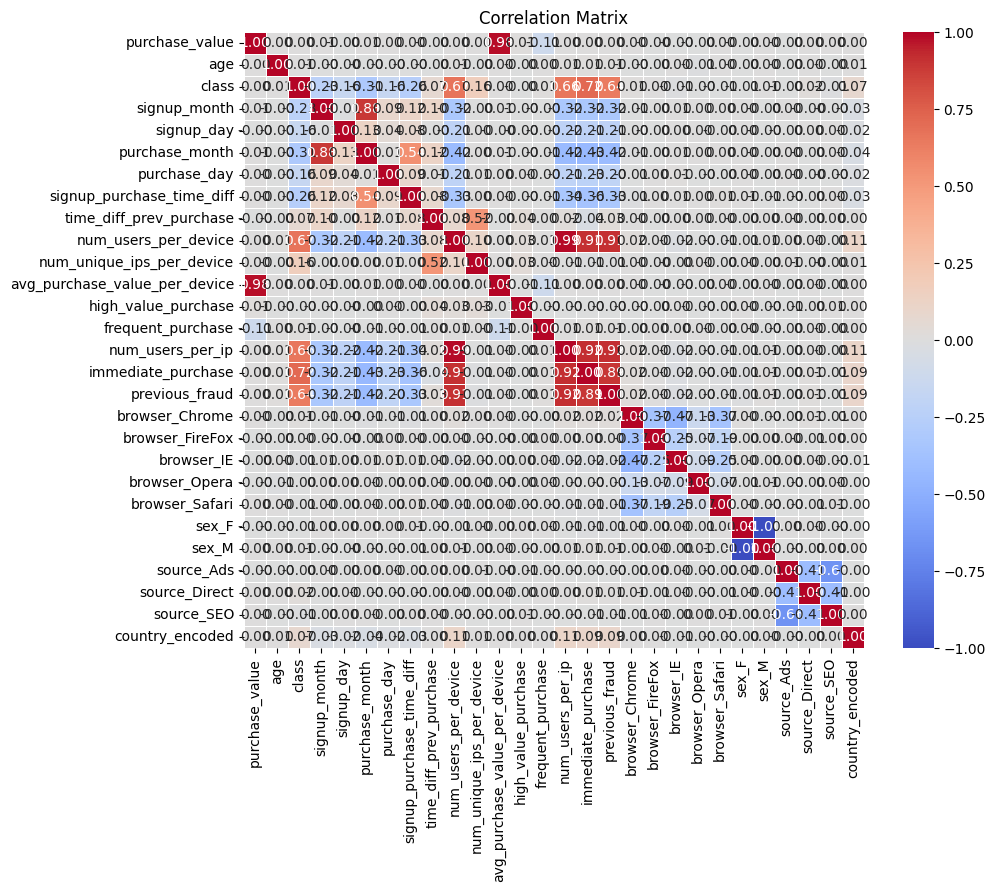

In [ ]:
# Checking for correlation between the features
corr_matrix = ohe_df.corr()
# Plotting heatmap to visualise the correlation between features
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

**Features with high correlation:**
1. purchase_month with signup month
2. purchase_month with signup_purchase_time_diff (remove purchase_month)
3. sex_M with sex_F (remove one of it)
4. The 5 browsers have relatively high correlation among one another (remove browser_IE)
5. the 3 sources have high correlation among one another (remove source_SEO)
6. average_purchase_value_per_device with purchase_value (remove average_purchase_value_per_device)
7. num_users_per_ip, immediate_purchase, previous fraud with multiple other features, including the class. (remove these 3)
8. num_users_per_device with previous_fraud (remove previous fraud)
9. time_diff_prev_purchase with num_unique_ips_per_device (remove time_diff_prev_purchase)

In [ ]:
corr_df = ohe_df.drop(columns=['purchase_month','sex_M','browser_IE','source_SEO', 'avg_purchase_value_per_device', 'num_users_per_ip', 'immediate_purchase', 'previous_fraud', 'time_diff_prev_purchase'])
corr_df.head(3)

,purchase_value,age,class,signup_month,signup_day,purchase_day,signup_purchase_time_diff,num_users_per_device,num_unique_ips_per_device,high_value_purchase,frequent_purchase,browser_Chrome,browser_FireFox,browser_Opera,browser_Safari,sex_F,source_Ads,source_Direct,country_encoded
34321,45,34,0,5,12,13,2792507.0,1,1,0,0,1,0,0,0,0,0,1,0.106236
57616,94,29,0,2,5,29,4414743.0,1,1,0,0,1,0,0,0,0,1,0,0.095626
46520,46,40,0,5,10,22,6316088.0,1,1,0,0,0,0,0,0,0,1,0,0.085723


In [ ]:
# Separating corr df into the class and features df
corr_y = corr_df['class']
corr_X = corr_df.drop(columns=['class'])

# Standardizing the dataframe
scaler = StandardScaler()
corr_features_scaled = scaler.fit_transform(corr_X)

# Spliting data
X_train, X_test, y_train, y_test = train_test_split(corr_features_scaled, corr_y, stratify=corr_y, test_size=0.2, random_state=42)

## Balancing data

In this section, we will be comparing the performance of various oversampling techniques, namely random oversampling, SMOTE, and its variants, ADASYN and class weights adjustment.
The baseline model we will be using to compare these methods will be the Decision Tree Classifier and Logistic Regression model from scikit-learn.

Undersampling techniques will not be used since too much data would be lost.

In [ ]:
%pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialising models
decision_tree_model = DecisionTreeClassifier(random_state=42)
logreg_model = LogisticRegression(random_state=42, max_iter=1000)

### SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# Frequency of each class after SMOTE
unique, counts = np.unique(y_smote, return_counts=True)
print(dict(zip(unique, counts)))

{0: 87674, 1: 87674}


In [ ]:
# SMOTE with Decision Tree
decision_tree_model.fit(X_smote, y_smote)
y_pred_dt = decision_tree_model.predict(X_test)
report_dt = classification_report(y_test, y_pred_dt)
print("SMOTE with Decision Tree:")
print(report_dt)

# SMOTE with Logistic Regression
logreg_model.fit(X_smote, y_smote)
y_pred_logreg = logreg_model.predict(X_test)
report_logreg = classification_report(y_test, y_pred_logreg)
print("SMOTE with Logistic Regression:")
print(report_logreg)

SMOTE with Decision Tree:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27393
           1       0.51      0.59      0.55      2830

    accuracy                           0.91     30223
   macro avg       0.73      0.77      0.75     30223
weighted avg       0.91      0.91      0.91     30223

SMOTE with Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27393
           1       0.52      0.71      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.74      0.82      0.77     30223
weighted avg       0.93      0.91      0.92     30223



Conclusion for SMOTE: SMOTE with Random Forest Classifier has the best performance out of all models generally, despite it having the lowest recall for fraud class.

### SMOTE-Tomek

In [ ]:
# Takes 5min to run
from imblearn.combine import SMOTETomek
from collections import Counter

tomek = SMOTETomek(random_state=42)
X_tomek, y_tomek = tomek.fit_resample(X_train, y_train)
print(Counter(y_tomek))

Counter({0: 87309, 1: 87309})


In [ ]:
# SMOTE-Tomek with Decision Tree
decision_tree_model.fit(X_tomek, y_tomek)
y_pred_dt = decision_tree_model.predict(X_test)
report_dt = classification_report(y_test, y_pred_dt)
print("SMOTE-Tomek with Decision Tree:")
print(report_dt)

# SMOTE-Tomek with Logistic Regression
logreg_model.fit(X_tomek, y_tomek)
y_pred_logreg = logreg_model.predict(X_test)
report_logreg = classification_report(y_test, y_pred_logreg)
print("SMOTE-Tomek with Logistic Regression:")
print(report_logreg)

SMOTE-Tomek with Decision Tree:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27393
           1       0.50      0.59      0.54      2830

    accuracy                           0.91     30223
   macro avg       0.73      0.77      0.75     30223
weighted avg       0.91      0.91      0.91     30223

SMOTE-Tomek with Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27393
           1       0.52      0.71      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.74      0.82      0.77     30223
weighted avg       0.93      0.91      0.92     30223



Conclusion for SMOTE-Tomek: Like SMOTE, Tomek with Random Forest Classifier has best performance generally, only falling short in recall for fraud class.

### SMOTE-ENN

In [ ]:
# Takes 5min to run
from imblearn.combine import SMOTEENN

enn = SMOTEENN(random_state=42)
X_enn, y_enn = enn.fit_resample(X_train, y_train)
print(Counter(y_enn))

Counter({1: 85066, 0: 67615})


In [ ]:
# SMOTE-ENN with Decision Tree
decision_tree_model.fit(X_enn, y_enn)
y_pred_dt = decision_tree_model.predict(X_test)
report_dt = classification_report(y_test, y_pred_dt)
print("SMOTE-ENN with Decision Tree:")
print(report_dt)

# SMOTE-ENN with Logistic Regression
logreg_model.fit(X_enn, y_enn)
y_pred_logreg = logreg_model.predict(X_test)
report_logreg = classification_report(y_test, y_pred_logreg)
print("SMOTE-ENN with Logistic Regression:")
print(report_logreg)

SMOTE-ENN with Decision Tree:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     27393
           1       0.43      0.65      0.52      2830

    accuracy                           0.89     30223
   macro avg       0.69      0.78      0.73     30223
weighted avg       0.91      0.89      0.90     30223

SMOTE-ENN with Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27393
           1       0.52      0.71      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.74      0.82      0.77     30223
weighted avg       0.93      0.91      0.92     30223



Conclusion for SMOTE-ENN: Like the other 2 SMOTE variants, ENN with Random Forest Classifier has the best performance generally. Unlike the other SMOTE variants with Random Forest Classifier, ENN  has better recall and poorer precision.

### ADASYN

In [ ]:
from imblearn.over_sampling import ADASYN

# Instantiate ADASYN
adasyn = ADASYN(random_state=42)

# Apply ADASYN to your dataset
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [ ]:
# Frequency of each class after ADASYN
unique, counts = np.unique(y_adasyn, return_counts=True)
print(dict(zip(unique, counts)))

{0: 87674, 1: 87832}


In [ ]:
# ADASYN with Decision Tree
decision_tree_model.fit(X_adasyn, y_adasyn)
y_pred_dt = decision_tree_model.predict(X_test)
report_dt = classification_report(y_test, y_pred_dt)
print("ADASYN with Decision Tree:")
print(report_dt)

# ADASYN with Logistic Regression
logreg_model.fit(X_adasyn, y_adasyn)
y_pred_logreg = logreg_model.predict(X_test)
report_logreg = classification_report(y_test, y_pred_logreg)
print("ADASYN with Logistic Regression:")
print(report_logreg)

ADASYN with Decision Tree:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     27393
           1       0.50      0.61      0.55      2830

    accuracy                           0.91     30223
   macro avg       0.73      0.77      0.75     30223
weighted avg       0.92      0.91      0.91     30223

ADASYN with Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27393
           1       0.51      0.71      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.74      0.82      0.77     30223
weighted avg       0.93      0.91      0.92     30223



Conclusion for ADASYN: Same as SMOTE and SMOTE-Tomek.

### Random Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Instantiate RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply random oversampling to your dataset
X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
# Frequency of each class after Random Oversampling
unique, counts = np.unique(y_ros, return_counts=True)
print(dict(zip(unique, counts)))

{0: 87674, 1: 87674}


In [ ]:
# Random Oversampling with Decision Tree
decision_tree_model.fit(X_ros, y_ros)
y_pred_dt = decision_tree_model.predict(X_test)
report_dt = classification_report(y_test, y_pred_dt)
print("Random Oversampling with Decision Tree:")
print(report_dt)

# Random Oversampling with Logistic Regression
logreg_model.fit(X_ros, y_ros)
y_pred_logreg = logreg_model.predict(X_test)
report_logreg = classification_report(y_test, y_pred_logreg)
print("Random Oversampling with Logistic Regression:")
print(report_logreg)

Random Oversampling with Decision Tree:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     27393
           1       0.56      0.58      0.57      2830

    accuracy                           0.92     30223
   macro avg       0.76      0.77      0.76     30223
weighted avg       0.92      0.92      0.92     30223

Random Oversampling with Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27393
           1       0.52      0.71      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.74      0.82      0.77     30223
weighted avg       0.93      0.91      0.92     30223



Conclusion for Random Oversampling: Same as SMOTE, SMOTE-Tomek and ADASYN.

### Adjusting Class Weights

In [ ]:
# Train models with class weights
weighted_decision_tree_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
weighted_logreg_model = LogisticRegression(random_state=42, class_weight='balanced')

# Fitting the models
weighted_decision_tree_model.fit(X_train, y_train)
weighted_logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dt = weighted_decision_tree_model.predict(X_test)
y_pred_logreg = weighted_logreg_model.predict(X_test)

# Generate classification report
report_dt = classification_report(y_test, y_pred_dt)
report_logreg = classification_report(y_test, y_pred_logreg)

# Print the classification report
print("Class Weights Adjustment with Decision Tree:")
print(report_dt)
print("Class Weights Adjustment with Logistic Regression:")
print(report_logreg)

Class Weights Adjustment with Decision Tree:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     27393
           1       0.57      0.58      0.57      2830

    accuracy                           0.92     30223
   macro avg       0.76      0.77      0.76     30223
weighted avg       0.92      0.92      0.92     30223

Class Weights Adjustment with Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     27393
           1       0.52      0.71      0.60      2830

    accuracy                           0.91     30223
   macro avg       0.74      0.82      0.77     30223
weighted avg       0.93      0.91      0.92     30223



Conclusion for Class Weights adjustment: Same as the other re-sampling techniques, using Class Weights adjustment with Random Forest Classifier yields the best performance. Performance is comparable with Random Oversampling, with Class Weights performing slightly better.

Overall Conclusion: Tomek and SMOTE have the same performance, ENN and ADASYN have poorer general performance than SMOTE and Tomek, and Random Oversampling and Class Weights adjustment has the best general performance.

Noteworthy: ENN has the weakest general performance, but it has the highest recall for fraud class as compared to all resampling methods.

Note: Random Oversampling and Class Weights adjustment are better than SMOTE and Tomek in all areas, except for recall for fraud class.

Final: Class Weight Adjustment has the best overall performance, with a slightly lower recall for fraud class, as compared to other resampling methods. As such, we will be using Class Weight Adjustment technique to address imbalanced data.

## Cross Validation for Decision Tree and Logistic Regression

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Initialise Stratified K Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate mean cross validation scores for Decision Tree model
cv_accuracy_dt = cross_val_score(weighted_decision_tree_model, corr_X, corr_y, cv=kf, scoring='accuracy')
cv_recall_dt = cross_val_score(weighted_decision_tree_model, corr_X, corr_y, cv=kf, scoring='recall')
cv_f1_dt = cross_val_score(weighted_decision_tree_model, corr_X, corr_y, cv=kf, scoring='f1')
cv_precision_dt = cross_val_score(weighted_decision_tree_model, corr_X, corr_y, cv=kf, scoring='precision')
print('Mean Accuracy for Decision Tree:', cv_accuracy_dt.mean())
print('Mean Recall for Decision Tree:', cv_recall_dt.mean())
print('Mean F1 for Decision Tree:', cv_f1_dt.mean())
print('Mean Precision for Decision Tree:', cv_precision_dt.mean())

# Calculate mean cross validation scores for Logistic Regression model
cv_accuracy_lr = cross_val_score(weighted_logreg_model, corr_X, corr_y, cv=kf, scoring='accuracy')
cv_recall_lr = cross_val_score(weighted_logreg_model, corr_X, corr_y, cv=kf, scoring='recall', error_score=0)
cv_f1_lr = cross_val_score(weighted_logreg_model, corr_X, corr_y, cv=kf, scoring='f1', error_score=0)
cv_precision_lr = cross_val_score(weighted_logreg_model, corr_X, corr_y, cv=kf, scoring='precision', error_score=0)
print('Mean Accuracy for Decision Tree:', cv_accuracy_lr.mean())
print('Mean Recall for Decision Tree:', cv_recall_lr.mean())
print('Mean F1 for Decision Tree:', cv_f1_lr.mean())
print('Mean Precision for Decision Tree:', cv_precision_lr.mean())

Mean Accuracy for Decision Tree: 0.9199467817535691
Mean Recall for Decision Tree: 0.5854693305940166
Mean F1 for Decision Tree: 0.5779431449356444
Mean Precision for Decision Tree: 0.5707709359156923


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Mean Accuracy for Decision Tree: 0.9063542274348461
Mean Recall for Decision Tree: 0.0
Mean F1 for Decision Tree: 0.0
Mean Precision for Decision Tree: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


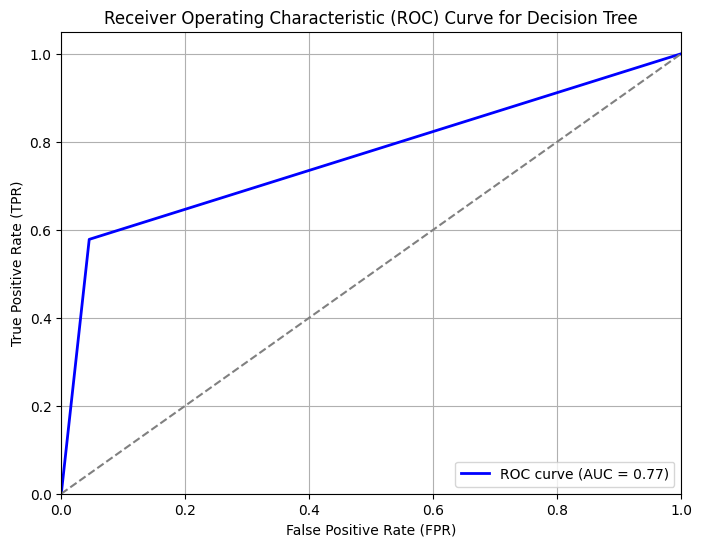

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

y_dt_proba = weighted_decision_tree_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_dt_proba)
auc_roc = roc_auc_score(y_test, y_dt_proba)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

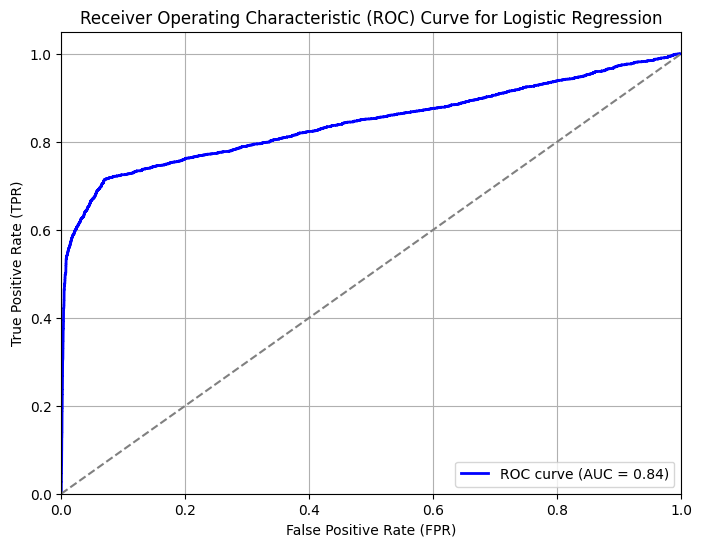

In [ ]:
y_logreg_proba = weighted_logreg_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_logreg_proba)
auc_roc = roc_auc_score(y_test, y_logreg_proba)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Challenger Model I: Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Assessing model performance before finetuning
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_report = classification_report(y_test, rf_pred)
print("Classification Report for Pre-tuned Random Forest:")
print(rf_report)
conf_matrix_rf = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix for Pre-tuned Random Forest:")
print(conf_matrix_rf)

# Calculate mean cross validation scores for Random Forest model, after finetuning
cv_accuracy_rf = cross_val_score(rf_model, corr_X, corr_y, cv=kf, scoring='accuracy')
cv_recall_rf = cross_val_score(rf_model, corr_X, corr_y, cv=kf, scoring='recall')
cv_f1_rf = cross_val_score(rf_model, corr_X, corr_y, cv=kf, scoring='f1')
cv_precision_rf = cross_val_score(rf_model, corr_X, corr_y, cv=kf, scoring='precision')
print('Mean Accuracy for Pre-tuned Random Forest:', cv_accuracy_rf.mean())
print('Mean Recall for Pre-tuned Random Forest:', cv_recall_rf.mean())
print('Mean F1 for Pre-tuned Random Forest:', cv_f1_rf.mean())
print('Mean Precision for Pre-tuned Random Forest:', cv_precision_rf.mean())

Classification Report for Pre-tuned Random Forest:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.99      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.96      0.95     30223

Confusion Matrix for Pre-tuned Random Forest:
[[27377    16]
 [ 1329  1501]]
Mean Accuracy for Pre-tuned Random Forest: 0.9563634813264285
Mean Recall for Pre-tuned Random Forest: 0.5389004122705083
Mean F1 for Pre-tuned Random Forest: 0.6980940254245576
Mean Precision for Pre-tuned Random Forest: 0.9910375152846088


### Hyperparameters Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

# Define the metrics for the scoring
scoring = {"AUC":"roc_auc",
           "Accuracy": make_scorer(accuracy_score),
           "Precision": make_scorer(precision_score),
           "Recall": make_scorer(recall_score),
           "F1": make_scorer(f1_score)}

# Specify the parameters for RandomizedSearchCV
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 4],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid,
                                   n_iter=10, cv=kf, scoring=scoring, random_state=42, refit="AUC")

# Fit the RandomizedSearchCV object
random_search.fit(X_train, y_train)
best_params_overall = random_search.best_params_

In [ ]:
best_params_overall

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30}

In [ ]:
# Based on the best hyperparameters from RandomisedSearch, build Random Forest Model
rf2 = RandomForestClassifier(random_state=42, class_weight='balanced', **best_params_overall)

# Assessing model performance after finetuning
rf2.fit(X_train, y_train)
rf2_pred = rf2.predict(X_test)
rf2_report = classification_report(y_test, rf2_pred)
print("Classification Report for Post-tuned Random Forest:")
print(rf2_report)
conf_matrix_rf2 = confusion_matrix(y_test, rf2_pred)
print("Confusion Matrix for Post-tuned Random Forest:")
print(conf_matrix_rf2)

Classification Report for Post-tuned Random Forest:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.95      0.54      0.69      2830

    accuracy                           0.95     30223
   macro avg       0.95      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223

Confusion Matrix for Post-tuned Random Forest:
[[27304    89]
 [ 1292  1538]]


In [ ]:
# Calculate mean cross validation scores for Random Forest model, after finetuning
cv_accuracy_rf2 = cross_val_score(rf2, corr_X, corr_y, cv=kf, scoring='accuracy')
cv_recall_rf2 = cross_val_score(rf2, corr_X, corr_y, cv=kf, scoring='recall')
cv_f1_rf2 = cross_val_score(rf2, corr_X, corr_y, cv=kf, scoring='f1')
cv_precision_rf2 = cross_val_score(rf2, corr_X, corr_y, cv=kf, scoring='precision')
print('Mean Accuracy for Post-tuned Random Forest:', cv_accuracy_rf2.mean())
print('Mean Recall for Post-tuned Random Forest:', cv_recall_rf2.mean())
print('Mean F1 for Post-tuned Random Forest:', cv_f1_rf2.mean())
print('Mean Precision for Post-tuned Random Forest:', cv_precision_rf2.mean())

Mean Accuracy for Post-tuned Random Forest: 0.9551789273685024
Mean Recall for Post-tuned Random Forest: 0.553104360731078
Mean F1 for Post-tuned Random Forest: 0.6979286098988775
Mean Precision for Post-tuned Random Forest: 0.9457470316060931


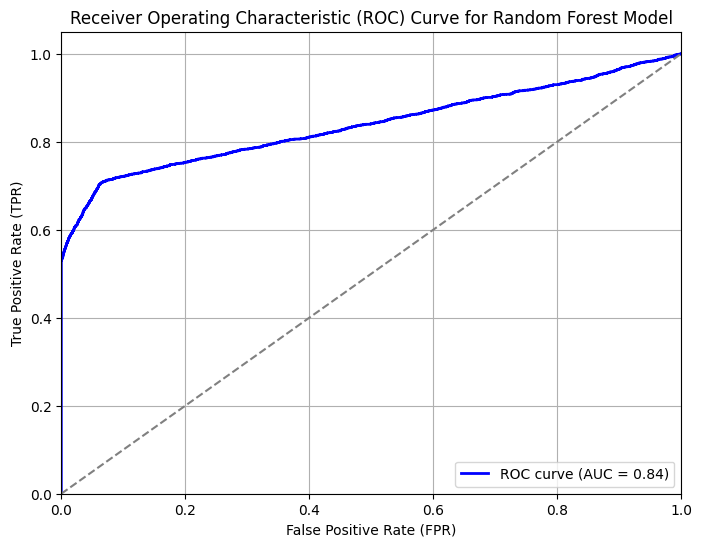

In [ ]:
y_rf_proba = rf2.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_rf_proba)
auc_roc = roc_auc_score(y_test, y_rf_proba)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

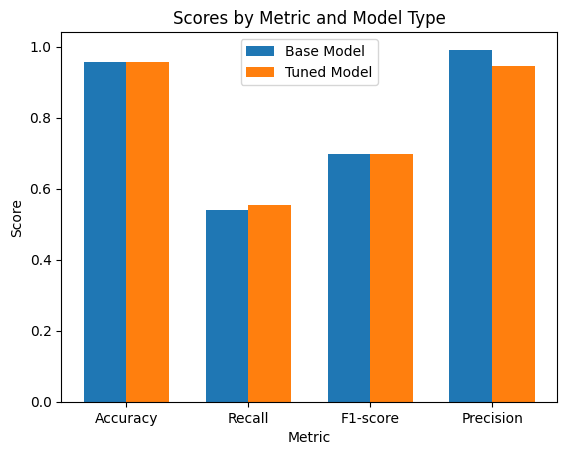

In [ ]:
# Creating dataframe to store the scores for the pre- and post-tuned Random Forest model
score_df = pd.DataFrame({
    'model_type': ['Base model', 'Base model', 'Base model', 'Base model',
                   'Tuned model', 'Tuned model', 'Tuned model', 'Tuned model'],
    'metric': ['Accuracy', 'Recall', 'F1-score', 'Precision',
               'Accuracy', 'Recall', 'F1-score', 'Precision'],
    'score': [cv_accuracy_rf.mean(), cv_recall_rf.mean(), cv_f1_rf.mean(), cv_precision_rf.mean(),
              cv_accuracy_rf2.mean(), cv_recall_rf2.mean(), cv_f1_rf2.mean(), cv_precision_rf2.mean()]
})

base_model_score = score_df[score_df['model_type'] == 'Base model']
tuned_model_score = score_df[score_df['model_type'] == 'Tuned model']

# Plotting barchart to compare the pre- and post- tune model performance
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(score_df['metric'].unique()))

bar1 = ax.bar(index, base_model_score['score'], bar_width, label='Base Model')
bar2 = ax.bar([i + bar_width for i in index], tuned_model_score['score'], bar_width, label='Tuned Model')

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Scores by Metric and Model Type')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(score_df['metric'].unique())
ax.legend()

plt.show()

## Challenger Model II: XGBoost

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for XGBoost Model')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot Precision-Recall curve
def plot_pr_curve(y_true, y_pred_proba, title):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

In [ ]:
%pip install xgboost
import xgboost as xgb
import scipy.stats as stats

def xgb_baseline_model(X_train, y_train, X_test, y_test):
    params = {'objective': 'binary:logistic'}
    xgb_model = xgb.XGBClassifier(**params)

    # Fit the baseline model
    xgb_model.fit(X_train, y_train)

    # Obtain predicted probabilities
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Fit model on test set
    y_pred = xgb_model.predict(X_test)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return xgb_model, y_pred


def xgb_model(X_train, y_train, X_test, y_test, class_weights=None):
    params = {'objective': 'binary:logistic'}
    if class_weights:
        class_counts = y_train.value_counts()
        total_samples = len(y_train)
        class_weights = total_samples / (2 * class_counts)
        params['scale_pos_weight'] = class_weights[1] / class_weights[0]
    xgb_model = xgb.XGBClassifier(**params)

    # Hyperparameter tuning
    params_tune = {'max_depth': stats.randint(3, 10),
                   'learning_rate': stats.uniform(0.01, 0.1),
                   'n_estimators': stats.randint(50, 200),
                   'subsample': stats.uniform(0.6, 0.4),
                   'colsample_bytree': stats.uniform(0.6, 0.4),
                   'min_child_weight': stats.randint(1, 5)
                  }
    random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=params_tune, cv=5, scoring='recall')
    random_search.fit(X_train, y_train)
    results = pd.DataFrame(random_search.cv_results_)
    best_params = random_search.best_params_
    print("Best Parameters:", best_params)

    # Obtain best model with best hyperparameters
    best_model = random_search.best_estimator_

    # Obtain predicted probabilities
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_proba)

    # Fit model on test set
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("XGBoost:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Calculate mean cross validation scores for XGBoost, after finetuning
    cv_accuracy_xgb = cross_val_score(best_model, corr_X, corr_y, cv=kf, scoring='accuracy')
    cv_recall_xgb = cross_val_score(best_model, corr_X, corr_y, cv=kf, scoring='recall')
    cv_f1_xgb = cross_val_score(best_model, corr_X, corr_y, cv=kf, scoring='f1')
    cv_precision_xgb = cross_val_score(best_model, corr_X, corr_y, cv=kf, scoring='precision')
    print('Mean Accuracy for Post-tuned XGBoost:', cv_accuracy_xgb.mean())
    print('Mean Recall for Post-tuned XGBoost:', cv_recall_xgb.mean())
    print('Mean F1 for Post-tuned XGBoost:', cv_f1_xgb.mean())
    print('Mean Precision for Post-tuned XGBoost:', cv_precision_xgb.mean())

    return best_model, y_pred

Best Parameters: {'colsample_bytree': 0.7642098322863375, 'learning_rate': 0.0948628544793939, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 55, 'subsample': 0.7590979888014608}


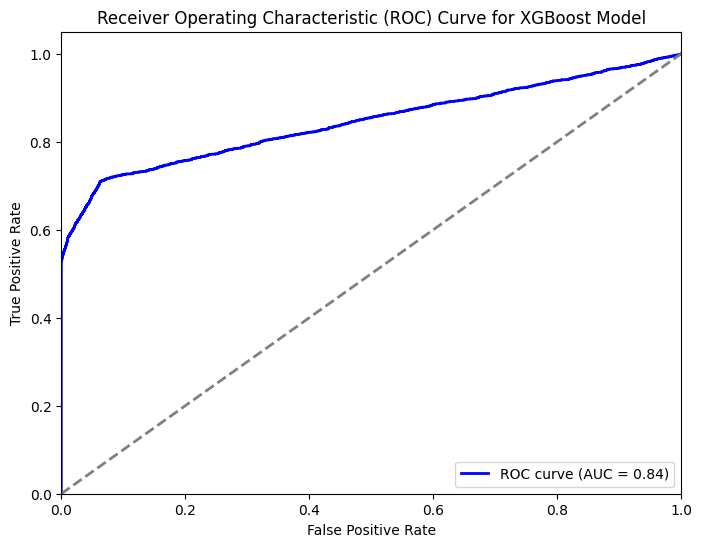

XGBoost:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27393
           1       0.54      0.71      0.61      2830

    accuracy                           0.92     30223
   macro avg       0.75      0.82      0.78     30223
weighted avg       0.93      0.92      0.92     30223

Confusion Matrix:
[[25647  1746]
 [  819  2011]]
Mean Accuracy for Post-tuned XGBoost: 0.9170416459585866
Mean Recall for Post-tuned XGBoost: 0.7145776505199252
Mean F1 for Post-tuned XGBoost: 0.6173368714136489
Mean Precision for Post-tuned XGBoost: 0.5434216793030222


In [ ]:
# Train XGBoost baseline model
xgb_baseline_model, y_pred_baseline = xgb_baseline_model(X_train, y_train, X_test, y_test)


# Train XGBoost model with class weights
xgb_model_with_weights, y_pred_tuned = xgb_model(X_train, y_train, X_test, y_test, class_weights=True)

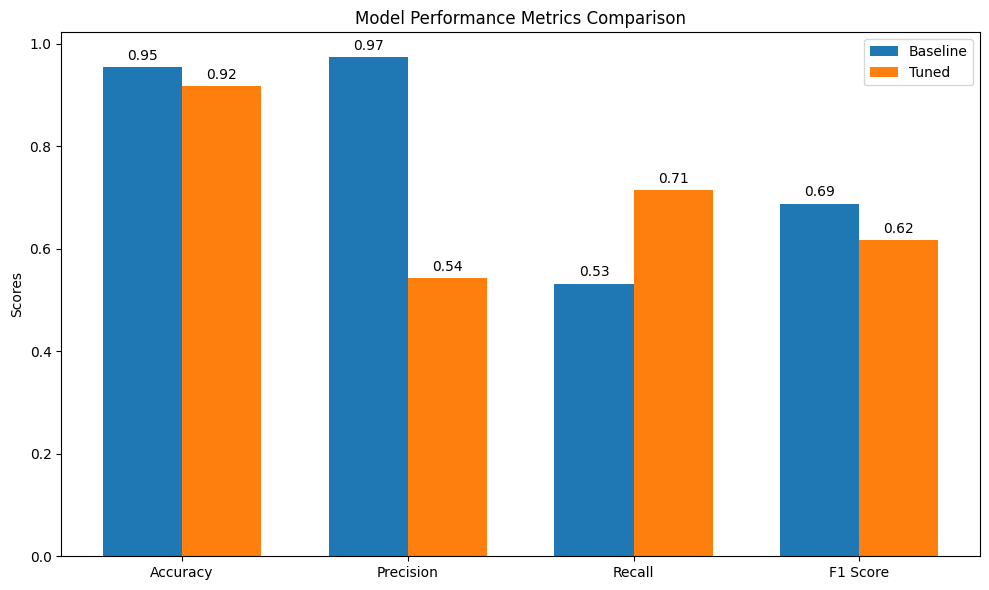

In [2]:
# Plotting comparison graph for metrics
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
baseline_scores = [accuracy_score(y_test, y_pred_baseline),
                   precision_score(y_test, y_pred_baseline),
                   recall_score(y_test, y_pred_baseline), 
                   f1_score(y_test, y_pred_baseline)]
tuned_scores = [accuracy_score(y_test, y_pred_tuned),
                   precision_score(y_test, y_pred_tuned),
                   recall_score(y_test, y_pred_tuned), 
                   f1_score(y_test, y_pred_tuned)]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, baseline_scores, width, label='Baseline')
rects2 = ax.bar(x + width/2, tuned_scores, width, label='Tuned')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

## Challenger Model III: Neural Network

In [ ]:
from sklearn.metrics import precision_recall_curve, confusion_matrix, classification_report
import numpy as np

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_curve, auc

X_train_val, X_test, y_train_val, y_test = train_test_split(corr_X, corr_y, stratify=corr_y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, test_size=0.2, random_state=42)

X_test = scaler.transform(X_test)

In [ ]:
from tensorflow import keras

METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          32, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [ ]:
basemodel = make_model()
basemodel.summary()
basemodel_history = basemodel.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                608       
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 641 (2.50 KB)
Trainable params: 641 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
3023/3023 [==============================] - 24s 7ms/step - loss: 0.1940 - cross entropy: 0.1940 - Brier score: 0.0471 - tp: 4572.0000 - fp: 556.0000 - tn: 87118.0000 - fn: 4465.0000 - accuracy: 0.9481 - precision: 0.8916 - recall: 0.5059 - auc: 0.8305 - prc: 0.6540 - val_los

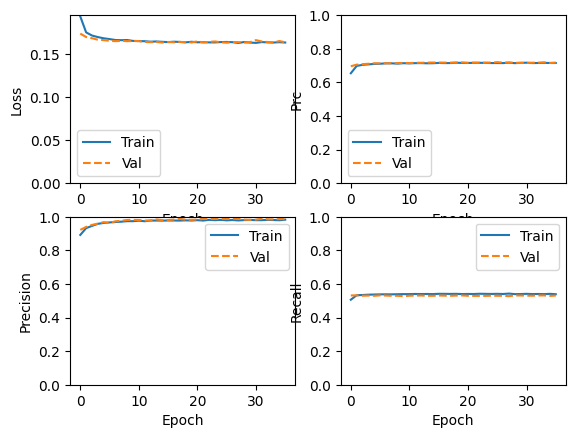

In [ ]:
plot_metrics(basemodel_history)

### Class Imbalance

#### Initial Weights

In [ ]:
df = corr_df
pos = len(df[df['class']==1])
neg = len(df[df['class']==0])
pos_neg_ratio = pos/neg
iw_model = make_model(output_bias=np.log(pos_neg_ratio))
results = iw_model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3420


In [ ]:
import tempfile
import os

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
iw_model.save_weights(initial_weights)

In [ ]:
iw_model = make_model()
iw_model.load_weights(initial_weights)
iw_model_history = iw_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

Epoch 1/100
3023/3023 [==============================] - 13s 4ms/step - loss: 0.1929 - cross entropy: 0.2560 - Brier score: 0.0653 - tp: 5564.0000 - fp: 501.0000 - tn: 196741.0000 - fn: 14794.0000 - accuracy: 0.9297 - precision: 0.9174 - recall: 0.2733 - auc: 0.7040 - prc: 0.4278 - val_loss: 0.1747 - val_cross entropy: 0.1747 - val_Brier score: 0.0431 - val_tp: 1211.0000 - val_fp: 101.0000 - val_tn: 21793.0000 - val_fn: 1073.0000 - val_accuracy: 0.9514 - val_precision: 0.9230 - val_recall: 0.5302 - val_auc: 0.8456 - val_prc: 0.6942
Epoch 2/100
3023/3023 [==============================] - 17s 6ms/step - loss: 0.1775 - cross entropy: 0.1775 - Brier score: 0.0431 - tp: 4767.0000 - fp: 382.0000 - tn: 87292.0000 - fn: 4270.0000 - accuracy: 0.9519 - precision: 0.9258 - recall: 0.5275 - auc: 0.8411 - prc: 0.6928 - val_loss: 0.1711 - val_cross entropy: 0.1711 - val_Brier score: 0.0423 - val_tp: 1211.0000 - val_fp: 80.0000 - val_tn: 21814.0000 - val_fn: 1073.0000 - val_accuracy: 0.9523 - val_pr

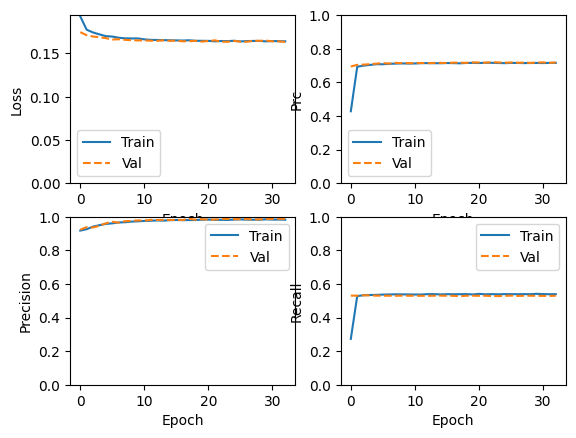

In [ ]:
plot_metrics(iw_model_history)

#### Class Weights

In [ ]:
weight_for_0 = (1 / neg) * ((neg+pos) / 2.0)
weight_for_1 = (1 / pos) * ((neg+pos) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.55
Weight for class 1: 5.34


In [ ]:
cw_model = make_model()

cw_model_history = cw_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    class_weight=class_weight)

Epoch 1/100
3023/3023 [==============================] - 13s 4ms/step - loss: 0.4707 - cross entropy: 0.4010 - Brier score: 0.1199 - tp: 7618.0000 - fp: 12932.0000 - tn: 96636.0000 - fn: 3703.0000 - accuracy: 0.8624 - precision: 0.3707 - recall: 0.6729 - auc: 0.8164 - prc: 0.6454 - val_loss: 0.3764 - val_cross entropy: 0.3764 - val_Brier score: 0.1021 - val_tp: 1647.0000 - val_fp: 1473.0000 - val_tn: 20421.0000 - val_fn: 637.0000 - val_accuracy: 0.9127 - val_precision: 0.5279 - val_recall: 0.7211 - val_auc: 0.8490 - val_prc: 0.6828
Epoch 2/100
3023/3023 [==============================] - 10s 3ms/step - loss: 0.4309 - cross entropy: 0.3959 - Brier score: 0.1107 - tp: 6455.0000 - fp: 6222.0000 - tn: 81452.0000 - fn: 2582.0000 - accuracy: 0.9090 - precision: 0.5092 - recall: 0.7143 - auc: 0.8431 - prc: 0.6802 - val_loss: 0.3555 - val_cross entropy: 0.3555 - val_Brier score: 0.0937 - val_tp: 1647.0000 - val_fp: 1473.0000 - val_tn: 20421.0000 - val_fn: 637.0000 - val_accuracy: 0.9127 - val_

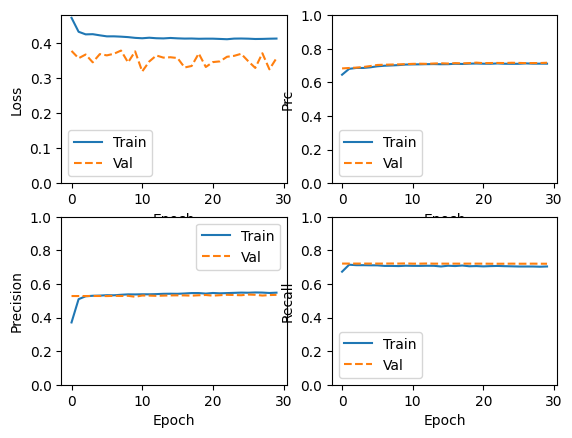

In [ ]:
plot_metrics(cw_model_history)

#### Initial Weights and Class Weights

In [ ]:
iw_cw_model = make_model()
iw_cw_model.load_weights(initial_weights)

iw_cw_model_history = iw_cw_model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val),
    class_weight=class_weight)

Epoch 1/100
3023/3023 [==============================] - 16s 5ms/step - loss: 0.4917 - cross entropy: 0.3765 - Brier score: 0.1043 - tp: 7520.0000 - fp: 8387.0000 - tn: 101181.0000 - fn: 3801.0000 - accuracy: 0.8992 - precision: 0.4727 - recall: 0.6643 - auc: 0.8177 - prc: 0.6371 - val_loss: 0.3619 - val_cross entropy: 0.3619 - val_Brier score: 0.0951 - val_tp: 1647.0000 - val_fp: 1476.0000 - val_tn: 20418.0000 - val_fn: 637.0000 - val_accuracy: 0.9126 - val_precision: 0.5274 - val_recall: 0.7211 - val_auc: 0.8462 - val_prc: 0.6750
Epoch 2/100
3023/3023 [==============================] - 12s 4ms/step - loss: 0.4321 - cross entropy: 0.3684 - Brier score: 0.0967 - tp: 6249.0000 - fp: 5142.0000 - tn: 82532.0000 - fn: 2788.0000 - accuracy: 0.9180 - precision: 0.5486 - recall: 0.6915 - auc: 0.8377 - prc: 0.6621 - val_loss: 0.3850 - val_cross entropy: 0.3850 - val_Brier score: 0.1023 - val_tp: 1647.0000 - val_fp: 1474.0000 - val_tn: 20420.0000 - val_fn: 637.0000 - val_accuracy: 0.9127 - val_

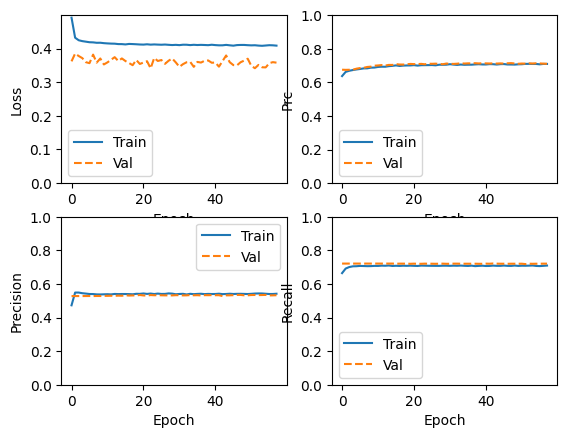

In [ ]:
plot_metrics(iw_cw_model_history)

#### Comparison

In [ ]:
def get_predictions(model):
  return model.predict(X_train, batch_size=BATCH_SIZE), model.predict(X_test, batch_size=BATCH_SIZE)

In [ ]:
base_pred = get_predictions(basemodel)
iw_pred = get_predictions(iw_model)
cw_pred = get_predictions(cw_model)
iw_cw_pred = get_predictions(iw_cw_model)

945/945 [==============================] - 1s 1ms/step


In [ ]:
preds = {'Base':base_pred, 'Initial Weights':iw_pred, 'Class Weights':cw_pred, 'Initial and Class Weights':iw_cw_pred}
colours = {'Base':'black', 'Initial Weights':'blue', 'Class Weights':'orange', 'Initial and Class Weights':'green'}

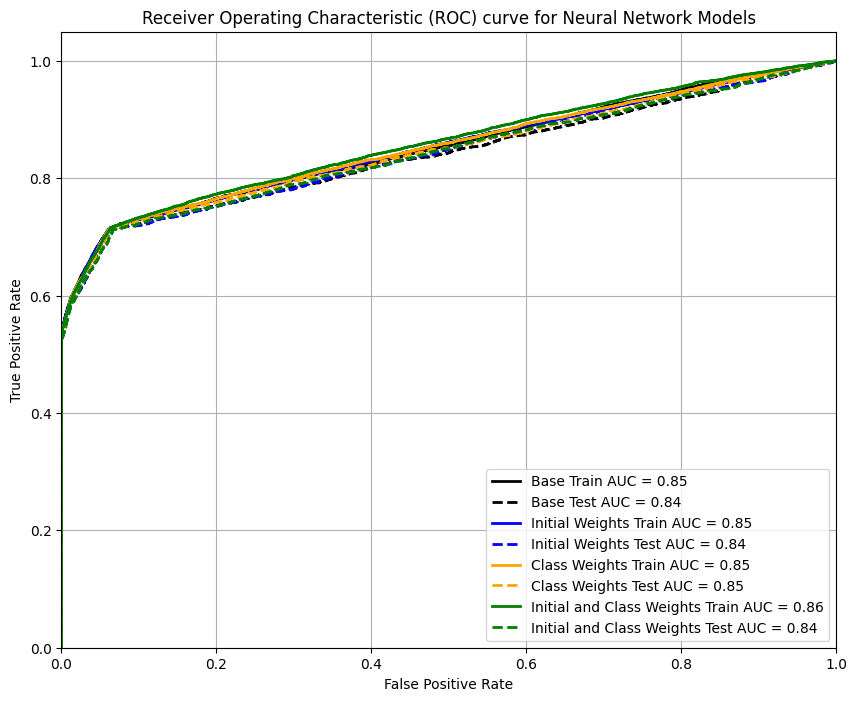

In [ ]:
plt.figure(figsize=(10, 8))

binary_preds = {}

for name, pred in preds.items():
  fpr_train, tpr_train, threshold = roc_curve(y_train, pred[0])
  roc_auc_train = auc(fpr_train, tpr_train)

  fpr_test, tpr_test, _ = roc_curve(y_test, pred[1])
  roc_auc_test = auc(fpr_test, tpr_test)

  optimal_idx = np.argmax(tpr_train - fpr_train)
  optimal_threshold = threshold[optimal_idx]

  pred_binary = np.where(pred[1] > optimal_threshold, 1, 0)

  binary_preds[name] = pred_binary

  plt.plot(fpr_train, tpr_train, color=colours[name], lw=2, label=f'{name} Train AUC = {roc_auc_train:0.2f}')
  plt.plot(fpr_test, tpr_test, color=colours[name], lw=2, label=f'{name} Test AUC = {roc_auc_test:0.2f}', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('Receiver Operating Characteristic (ROC) curve for Neural Network Models')
plt.legend(loc="lower right")
plt.show()

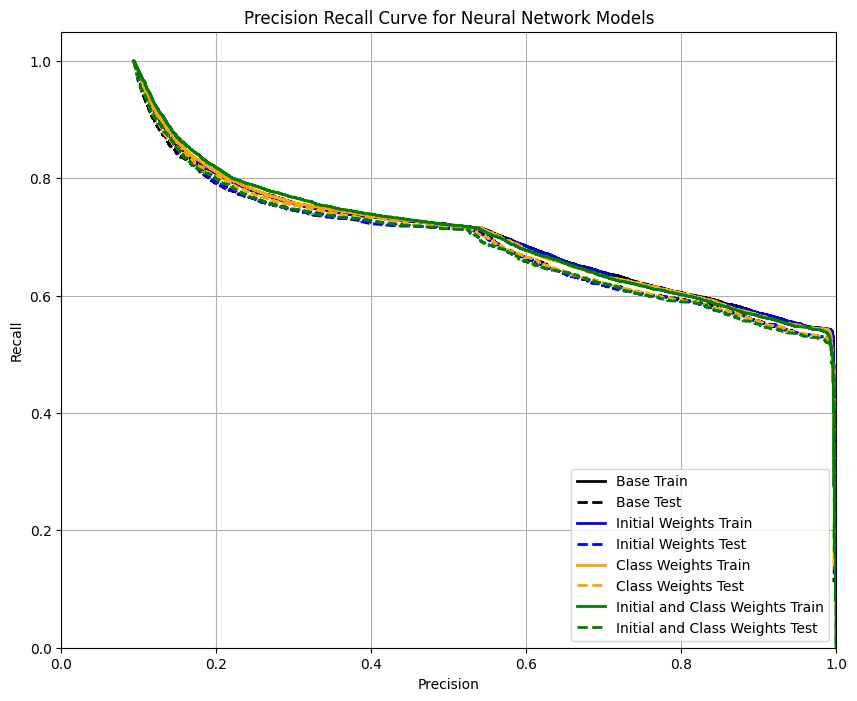

In [ ]:
plt.figure(figsize=(10, 8))

for name, pred in preds.items():
  precision_train, recall_train, _ = precision_recall_curve(y_train, pred[0])
  precision_test, recall_test, _ = precision_recall_curve(y_test, pred[1])

  plt.plot(precision_train, recall_train, color=colours[name], lw=2, label = f'{name} Train')
  plt.plot(precision_test, recall_test, color=colours[name], lw=2, linestyle='--', label = f'{name} Test')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.title('Precision Recall Curve for Neural Network Models')
plt.legend(loc="lower right")
plt.show()

In [ ]:
for name, pred in binary_preds.items():
  print(name + '\n')
  print(confusion_matrix(y_test, pred))
  print('\n')
  print(classification_report(y_test, pred))

Base

[[25628  1765]
 [  819  2011]]


              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27393
           1       0.53      0.71      0.61      2830

    accuracy                           0.91     30223
   macro avg       0.75      0.82      0.78     30223
weighted avg       0.93      0.91      0.92     30223

Initial Weights

[[25627  1766]
 [  817  2013]]


              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27393
           1       0.53      0.71      0.61      2830

    accuracy                           0.91     30223
   macro avg       0.75      0.82      0.78     30223
weighted avg       0.93      0.91      0.92     30223

Class Weights

[[25617  1776]
 [  816  2014]]


              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27393
           1       0.53      0.71      0.61      2830

    accuracy                           0.91  

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Neural Network Model')
    plt.legend(loc="lower right")
    plt.show()

945/945 [==============================] - 4s 4ms/step


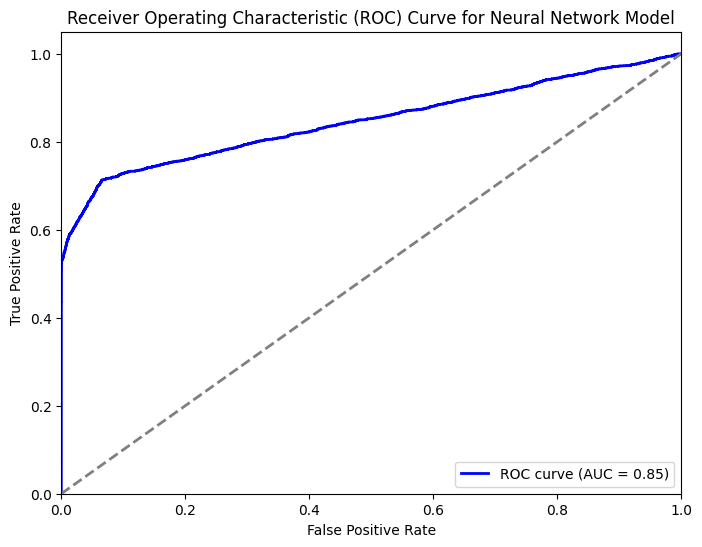

In [ ]:
plot_roc_curve(y_test, basemodel.predict(X_test))

### Neurons

In [ ]:
def model_set_neurons(metrics=METRICS, num=32):
  model = keras.Sequential([
      keras.layers.Dense(
          num, activation='relu',
          input_shape=(X_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid'),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [ ]:
models = {}
auc_scores = {}

for i in range(18, 40):
  model = model_set_neurons(num=i)
  history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val, y_val))

  models[i] = model
  auc_scores[i] = history.history['auc']

Epoch 1/100
3023/3023 [==============================] - 25s 7ms/step - loss: 0.2396 - cross entropy: 0.2633 - Brier score: 0.0685 - tp: 5636.0000 - fp: 3244.0000 - tn: 106324.0000 - fn: 5685.0000 - accuracy: 0.9261 - precision: 0.6347 - recall: 0.4978 - auc: 0.8122 - prc: 0.5877 - val_loss: 0.1738 - val_cross entropy: 0.1738 - val_Brier score: 0.0430 - val_tp: 1207.0000 - val_fp: 101.0000 - val_tn: 21793.0000 - val_fn: 1077.0000 - val_accuracy: 0.9513 - val_precision: 0.9228 - val_recall: 0.5285 - val_auc: 0.8468 - val_prc: 0.6920
Epoch 2/100
3023/3023 [==============================] - 12s 4ms/step - loss: 0.1863 - cross entropy: 0.1863 - Brier score: 0.0445 - tp: 4643.0000 - fp: 330.0000 - tn: 87344.0000 - fn: 4394.0000 - accuracy: 0.9512 - precision: 0.9336 - recall: 0.5138 - auc: 0.8412 - prc: 0.6854 - val_loss: 0.1704 - val_cross entropy: 0.1704 - val_Brier score: 0.0421 - val_tp: 1208.0000 - val_fp: 84.0000 - val_tn: 21810.0000 - val_fn: 1076.0000 - val_accuracy: 0.9520 - val_pr

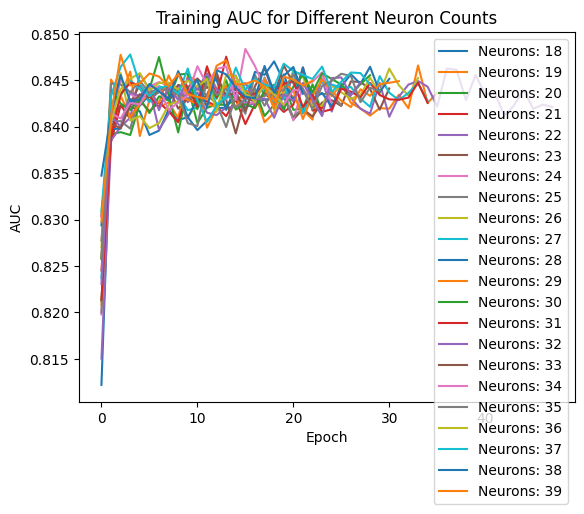

In [ ]:
for num, score in auc_scores.items():
    plt.plot(score, label=f'Neurons: {num}')

plt.title('Training AUC for Different Neuron Counts')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

945/945 [==============================] - 1s 1ms/step


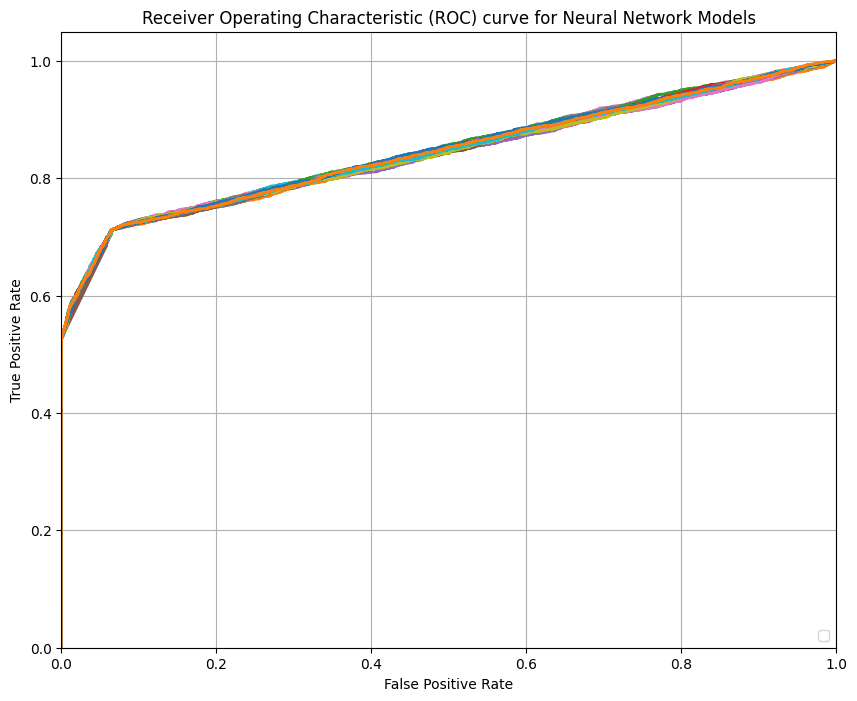

In [ ]:
plt.figure(figsize=(10, 8))

for num, model in models.items():
  fpr, tpr, _ = roc_curve(y_test, model.predict(X_test, batch_size=BATCH_SIZE))
  roc_auc = auc(fpr, tpr)

  plt.plot(fpr, tpr, lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.title('Receiver Operating Characteristic (ROC) curve for Neural Network Models')
plt.legend(loc="lower right")
plt.show()